# ANNDL Second Homework - MODELS

## Set Environment

### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import matplotlib.pyplot as plt
from keras.optimizers import AdamW
from keras.models import Model, Sequential, load_model
from keras.layers import Input, LSTM, Bidirectional, Dense, Attention, Reshape, Dropout, GRU, SimpleRNN, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Connect to Drive

In [ ]:
# Add ANNDL_Homework_2 folder to My Drive shortcuts!
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANNDL_Homework_2

Mounted at /gdrive
/gdrive/My Drive/ANNDL_Homework_2


## Load Data

In [ ]:
# Load arrays from file
normalizer = False
pattern = True

if normalizer and not pattern:
    # data = np.load('Stride_218.npz')
    data = np.load('Stride_218_NORM_Data.npz')

    # Access the loaded arrays
    x_train = data['x_train']
    y_train = data['y_train']
    x_val = data['x_val']
    y_val = data['y_val']
    x_test = data['x_test']
    y_test = data['y_test']
elif not pattern:
    # Load arrays from file
    # data = np.load('Stride_218.npz')
    data = np.load('Stride_218_float32.npz')
    # data = np.load('Stride_218_NO-Zero_padding.npz')

    # Access the loaded arrays
    x_train = data['x_train']
    y_train = data['y_train']
    x_val = data['x_val']
    y_val = data['y_val']
    x_test = data['x_test']
    y_test = data['y_test']
else:
    data = np.load('Relevant_Patterns.npz')

    # Access the loaded arrays
    x_train = data['x_train']
    y_train = data['y_train']
    x_val = data['x_val']
    y_val = data['y_val']
    x_test = data['x_test']
    y_test = data['y_test']

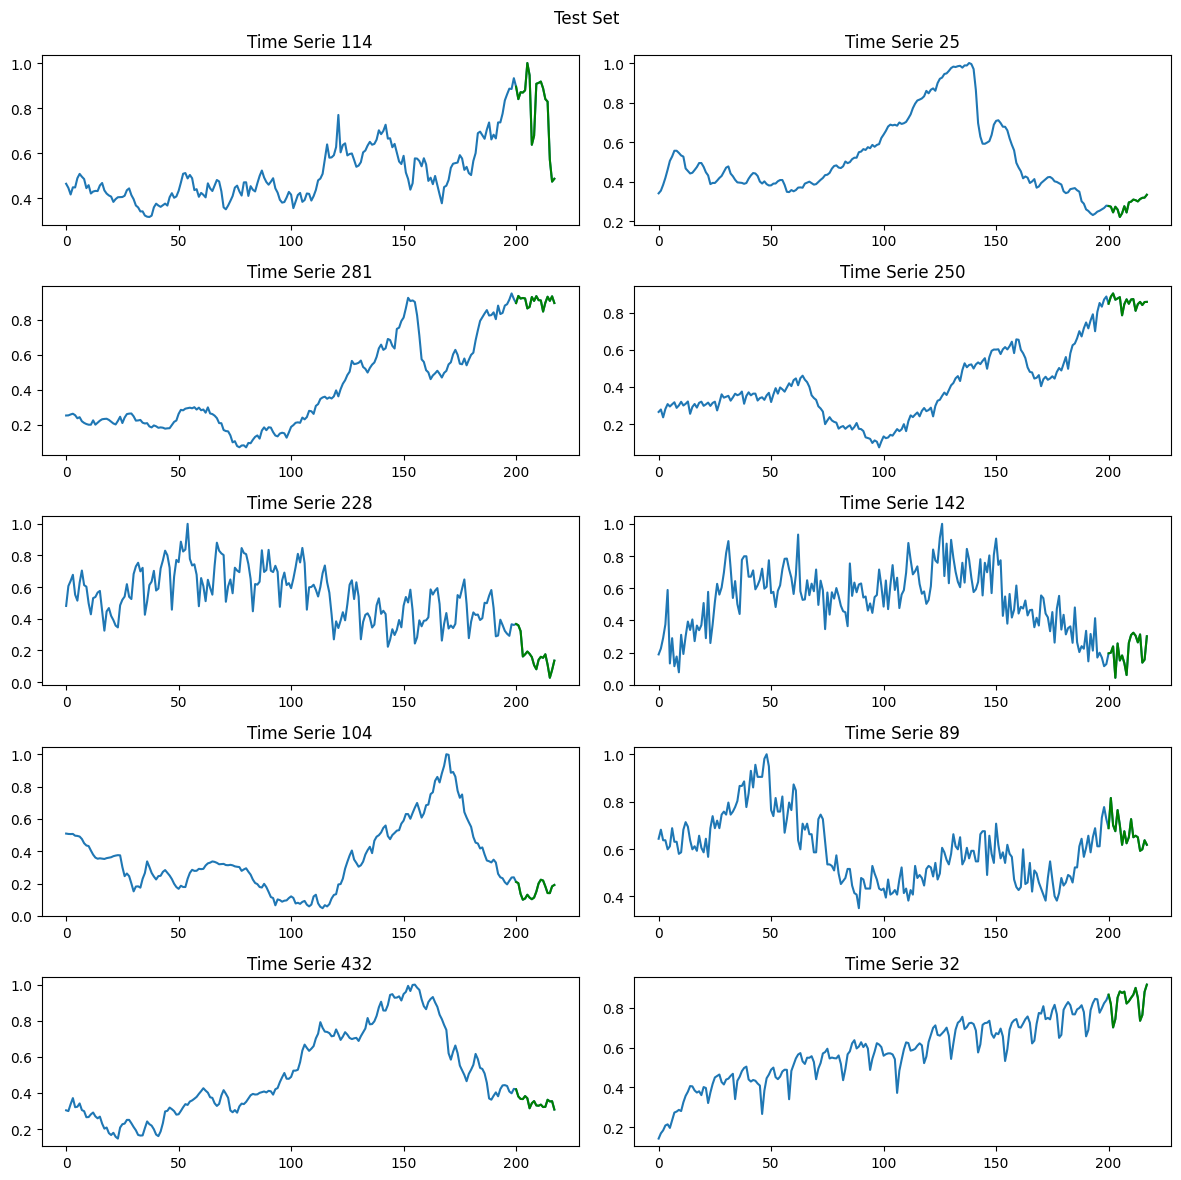

In [ ]:
# Create the figure and axes
figure, axes = plt.subplots(5, 2, figsize=(12, 12))

# Create an array filled with NaN values
empty = np.full((x_test.shape[0], 200), np.nan)

# Generate 2 random row indices
random_rows = random.sample(range(x_test.shape[0]), 10)

# Iterate through subplot grid
for i, ax in enumerate(axes.flatten()):
    row_index = random_rows[i]

    # Plot the original, green, and red lines with different line styles
    ax.plot(np.concatenate((x_test[row_index], y_test[row_index])))
    ax.plot(np.concatenate((empty[row_index], y_test[row_index])), color='green')
    # ax.plot(np.concatenate((empty[row_index], predictions[row_index])), color='red')

    # Set the title
    ax.set_title(f'Time Serie {row_index}')

# Set the suptitle, adjust layout, and show the plot
plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

## Important Models

The models used in order to obtain the best result on CodaLab

###First LSTM model

Our first model

In [ ]:
# Define the BidirectionalLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(256), input_shape=(200, 1)))
model.add(Dense(18))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32, callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.1, min_lr=1e-5)
])

Epoch 1/200
1104/1104 [==============================] - 31s 24ms/step - loss: 0.0283 - val_loss: 0.0245 - lr: 0.0010
Epoch 2/200
1104/1104 [==============================] - 26s 23ms/step - loss: 0.0234 - val_loss: 0.0232 - lr: 0.0010
Epoch 3/200
1104/1104 [==============================] - 27s 24ms/step - loss: 0.0219 - val_loss: 0.0231 - lr: 0.0010
Epoch 4/200
1104/1104 [==============================] - 25s 23ms/step - loss: 0.0216 - val_loss: 0.0231 - lr: 0.0010
Epoch 5/200
1104/1104 [==============================] - 25s 23ms/step - loss: 0.0211 - val_loss: 0.0214 - lr: 0.0010
Epoch 6/200
1104/1104 [==============================] - 26s 23ms/step - loss: 0.0205 - val_loss: 0.0214 - lr: 0.0010
Epoch 7/200
1104/1104 [==============================] - 25s 23ms/step - loss: 0.0202 - val_loss: 0.0202 - lr: 0.0010
Epoch 8/200
1104/1104 [==============================] - 27s 24ms/step - loss: 0.0193 - val_loss: 0.0194 - lr: 0.0010
Epoch 9/200
1104/1104 [==============================] -

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (4010, 18)
Mean Squared Error: 0.013448163866996765
Mean Absolute Error: 0.07961199432611465


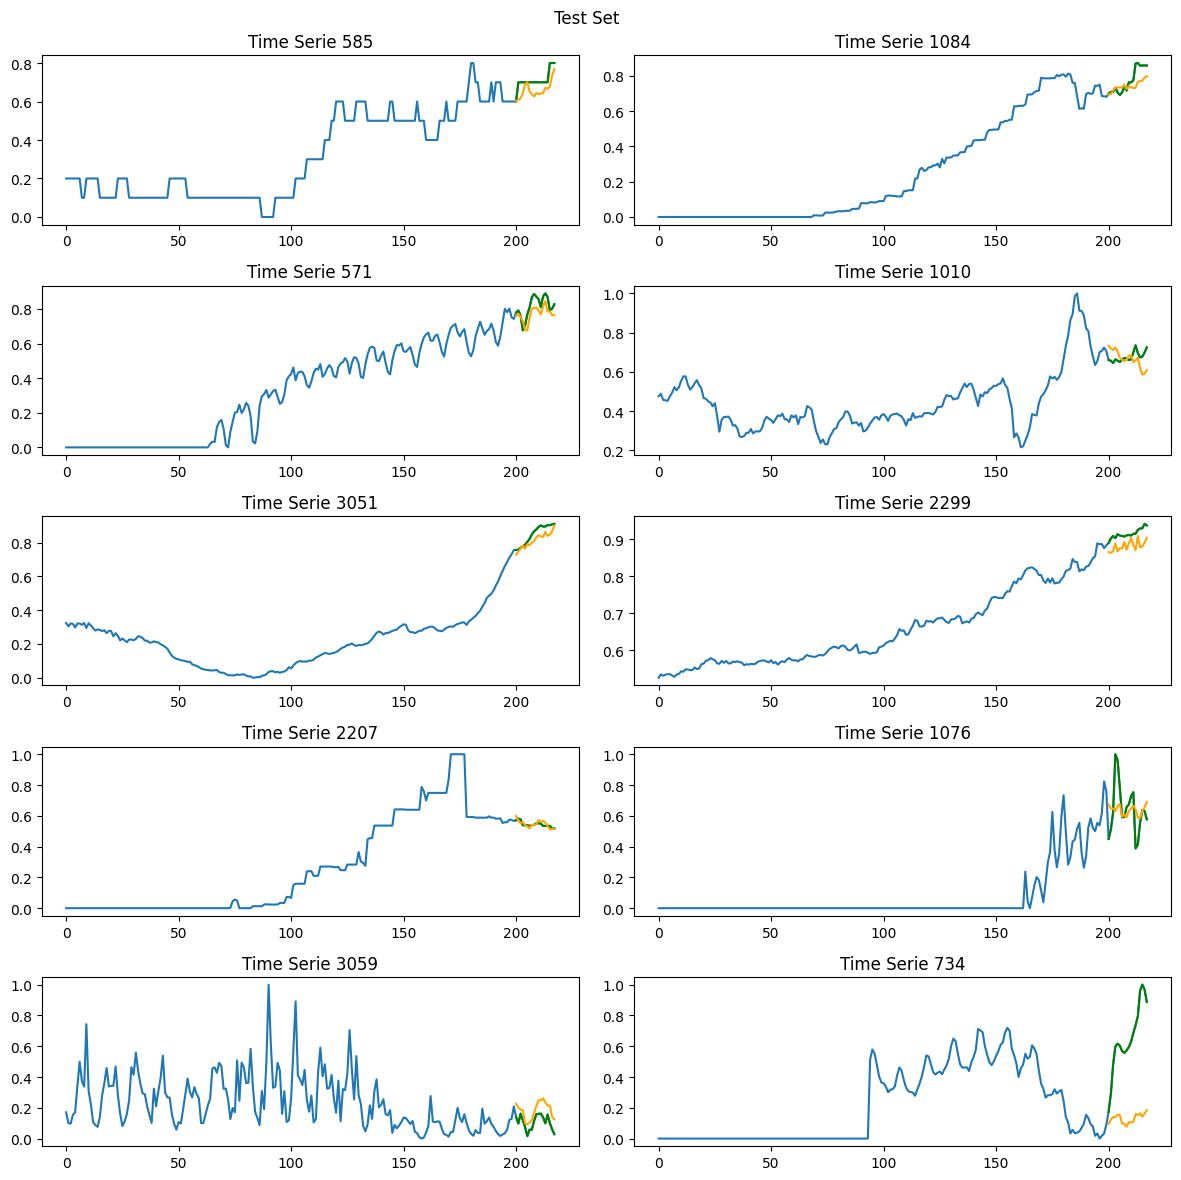

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(12, 12))

empty = np.zeros([X_test.shape[0], 200])
empty[empty == 0] = np.nan  # Set empty values to NaN

# Generate 2 random row indices
random_rows = random.sample(range(X_test.shape[0]), 9)
random_rows.append(734)

for i, row_index in enumerate(random_rows):
    row = i // 2
    col = i % 2
    axs[row, col].plot(np.concatenate((X_test[row_index], y_test[row_index])))
    axs[row, col].plot(np.concatenate((empty[row_index], y_test[row_index])), color='green')
    axs[row, col].plot(np.concatenate((empty[row_index], predictions[row_index])), color='orange')
    axs[row, col].set_title(f'Time Serie {row_index}')

plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

###Baseline model

This is the model that reached 0.0047 mse on codaLab in the development phase.

In [ ]:
# Define the BidirectionalLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=(200, 1)))
model.add(Bidirectional(LSTM(256), input_shape=(200, 1)))
model.add(Dense(18))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

# Train the model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=32, callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.1, min_lr=1e-5)
])

Epoch 1/200
1202/1202 [==============================] - 72s 54ms/step - loss: 0.0264 - val_loss: 0.0225 - lr: 0.0010
Epoch 2/200
1202/1202 [==============================] - 63s 52ms/step - loss: 0.0217 - val_loss: 0.0201 - lr: 0.0010
Epoch 3/200
1202/1202 [==============================] - 63s 52ms/step - loss: 0.0201 - val_loss: 0.0192 - lr: 0.0010
Epoch 4/200
1202/1202 [==============================] - 64s 53ms/step - loss: 0.0192 - val_loss: 0.0188 - lr: 0.0010
Epoch 5/200
1202/1202 [==============================] - 63s 53ms/step - loss: 0.0185 - val_loss: 0.0175 - lr: 0.0010
Epoch 6/200
1202/1202 [==============================] - 63s 52ms/step - loss: 0.0178 - val_loss: 0.0173 - lr: 0.0010
Epoch 7/200
1202/1202 [==============================] - 63s 52ms/step - loss: 0.0171 - val_loss: 0.0173 - lr: 0.0010
Epoch 8/200
1202/1202 [==============================] - 63s 52ms/step - loss: 0.0168 - val_loss: 0.0168 - lr: 0.0010
Epoch 9/200
1202/1202 [==============================] -

In [ ]:
# Predict the test set using the model
predictions = model.predict(x_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (5234, 18)
Mean Squared Error: 0.01781514659523964
Mean Absolute Error: 0.09343045949935913


In [ ]:
model.save('BiLSTM2')

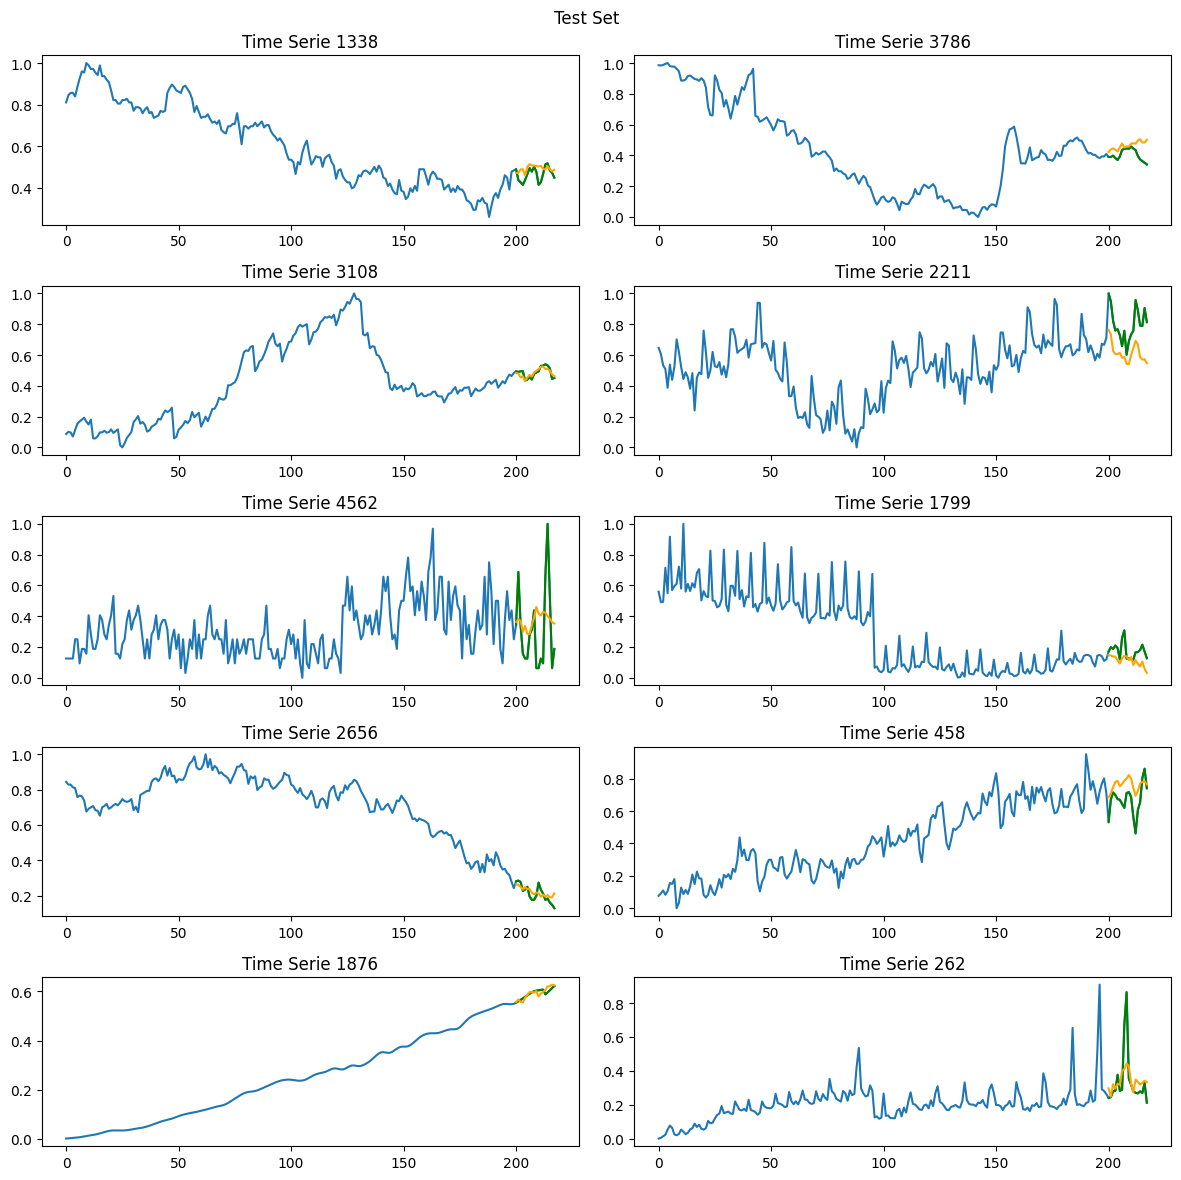

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(12, 12))

empty = np.zeros([x_test.shape[0], 200])
empty[empty == 0] = np.nan  # Set empty values to NaN

# Generate 2 random row indices
random_rows = random.sample(range(x_test.shape[0]), 10)

for i, row_index in enumerate(random_rows):
    row = i // 2
    col = i % 2
    axs[row, col].plot(np.concatenate((x_test[row_index], y_test[row_index])))
    axs[row, col].plot(np.concatenate((empty[row_index], y_test[row_index])), color='green')
    axs[row, col].plot(np.concatenate((empty[row_index], predictions[row_index])), color='orange')
    axs[row, col].set_title(f'Time Serie {row_index}')

plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

### Stationary Model

This is the model trained with stationary data. The process to generate the data is included in the **DATA** notebook

In [ ]:
# Load arrays from file
data = np.load('Stationary_Data.npz')

# Access the loaded arrays
x_train, y_train, x_val, y_val, x_test, y_test = data['x_train'], data['y_train'], data['x_val'], data['y_val'], data['x_test'], data['y_test']

In [ ]:
from keras.layers import Input, LSTM, Bidirectional, Dense, Attention, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the input layer
inputs = Input(shape=(199, 1))

# Apply Bidirectional LSTM
lstm_output = Bidirectional(LSTM(256, return_sequences=True))(inputs)

# Apply Attention layer with query and value inputs
attention_output = Attention()([lstm_output, lstm_output])

# Apply Bidirectional LSTM on the attention output
lstm_output_2 = Bidirectional(LSTM(256))(attention_output)

# Add the final dense layer
output = Dense(18)(lstm_output_2)

# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks = [
              tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=7, restore_best_weights=True),
              tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)
          ])

Epoch 1/100
512/512 [==============================] - 48s 65ms/step - loss: 0.0064 - val_loss: 0.0062 - lr: 0.0010
Epoch 2/100
512/512 [==============================] - 32s 63ms/step - loss: 0.0063 - val_loss: 0.0061 - lr: 0.0010
Epoch 3/100
512/512 [==============================] - 31s 61ms/step - loss: 0.0059 - val_loss: 0.0055 - lr: 0.0010
Epoch 4/100
512/512 [==============================] - 31s 60ms/step - loss: 0.0054 - val_loss: 0.0050 - lr: 0.0010
Epoch 5/100
512/512 [==============================] - 30s 58ms/step - loss: 0.0050 - val_loss: 0.0048 - lr: 0.0010
Epoch 6/100
512/512 [==============================] - 30s 58ms/step - loss: 0.0049 - val_loss: 0.0049 - lr: 0.0010
Epoch 7/100
512/512 [==============================] - 29s 56ms/step - loss: 0.0047 - val_loss: 0.0045 - lr: 0.0010
Epoch 8/100
512/512 [==============================] - 29s 57ms/step - loss: 0.0046 - val_loss: 0.0045 - lr: 0.0010
Epoch 9/100
512/512 [==============================] - 29s 56ms/step - l

In [ ]:
# Evaluate the model on the test set
mse = model.evaluate(dd_x_test, dd_y_test)

# Make predictions
predictions = model.predict(dd_x_test)

17/17 [==============================] - 3s 28ms/step


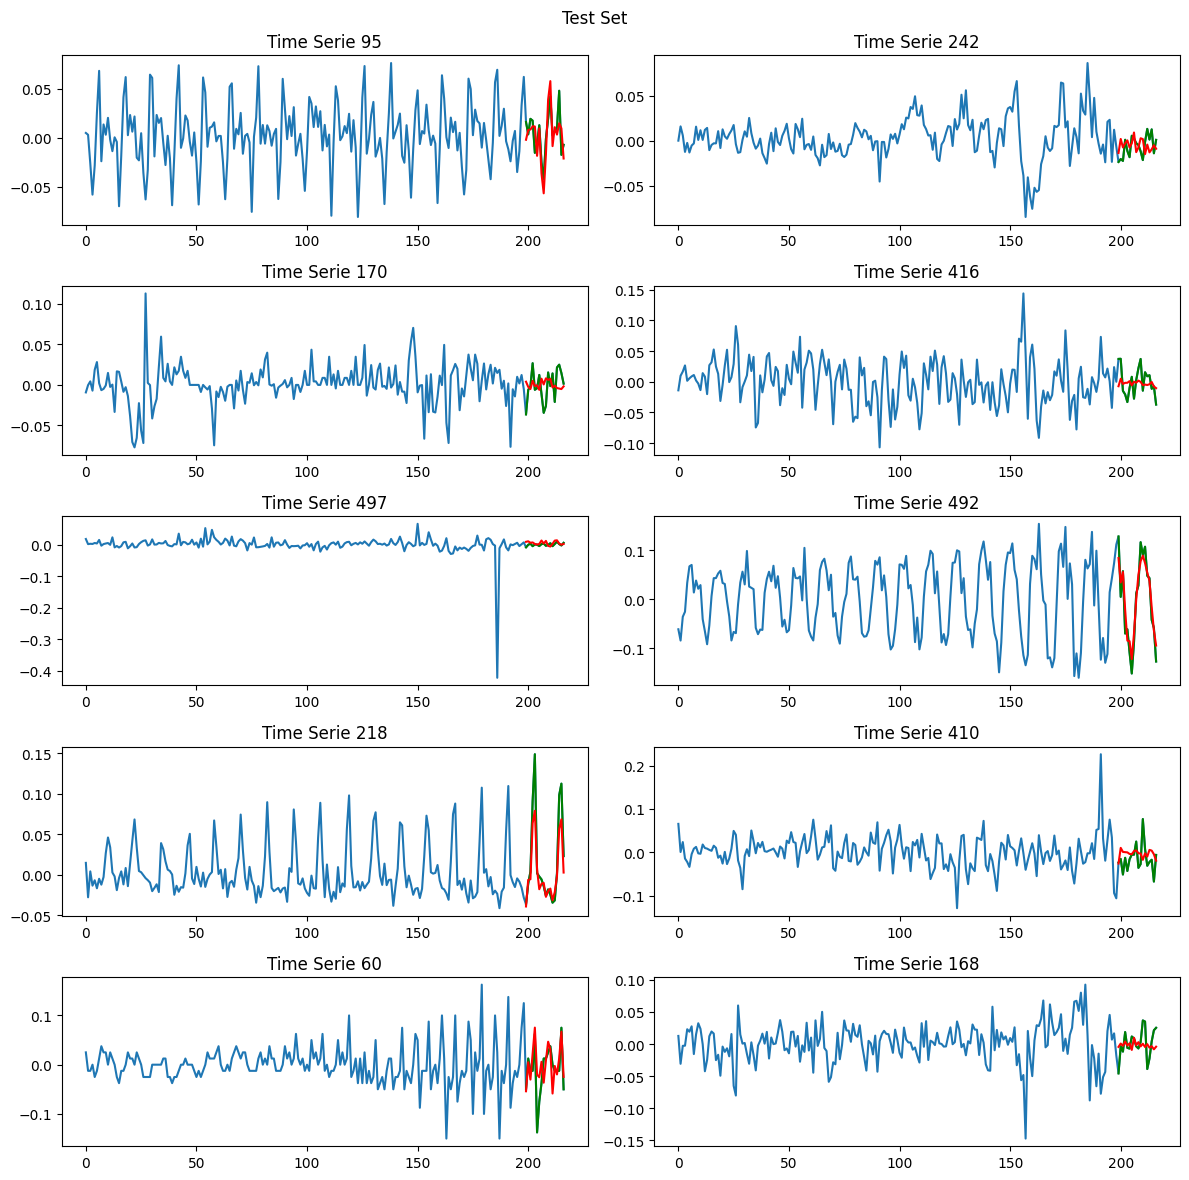

In [ ]:
# Create the figure and axes
figure, axes = plt.subplots(5, 2, figsize=(12, 12))

# Create an array filled with NaN values
empty = np.full((dd_x_test.shape[0], 199), np.nan)

# Generate 2 random row indices
random_rows = random.sample(range(dd_x_test.shape[0]), 10)

# Iterate through subplot grid
for i, ax in enumerate(axes.flatten()):
    row_index = random_rows[i]

    # Plot the original, green, and red lines with different line styles
    ax.plot(np.concatenate((dd_x_test[row_index], dd_y_test[row_index])))
    ax.plot(np.concatenate((empty[row_index], dd_y_test[row_index])), color='green')
    ax.plot(np.concatenate((empty[row_index], predictions[row_index])), color='red')

    # Set the title
    ax.set_title(f'Time Serie {row_index}')

# Set the suptitle, adjust layout, and show the plot
plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

In [ ]:
# Load original data and keep only the test set to see how the model predicts it
data = np.load('Stride_218_float32.npz')

# Access the test set's arrays
x_test, y_test = data['x_test'], data['y_test']

In [ ]:
# Specify the initial values (starting points of the original array along axis 1)
initial_x_values = x_test[:, -1]

# Prepend the initial values to the differences array along axis 1
differences = np.column_stack([initial_x_values, predictions])

# Reconstruct the original array by cumulatively summing the differences along axis 1
out = np.cumsum(differences, axis=1)

out = out[:, 1:]

In [ ]:
# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test - out) ** 2)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.012004730455059186


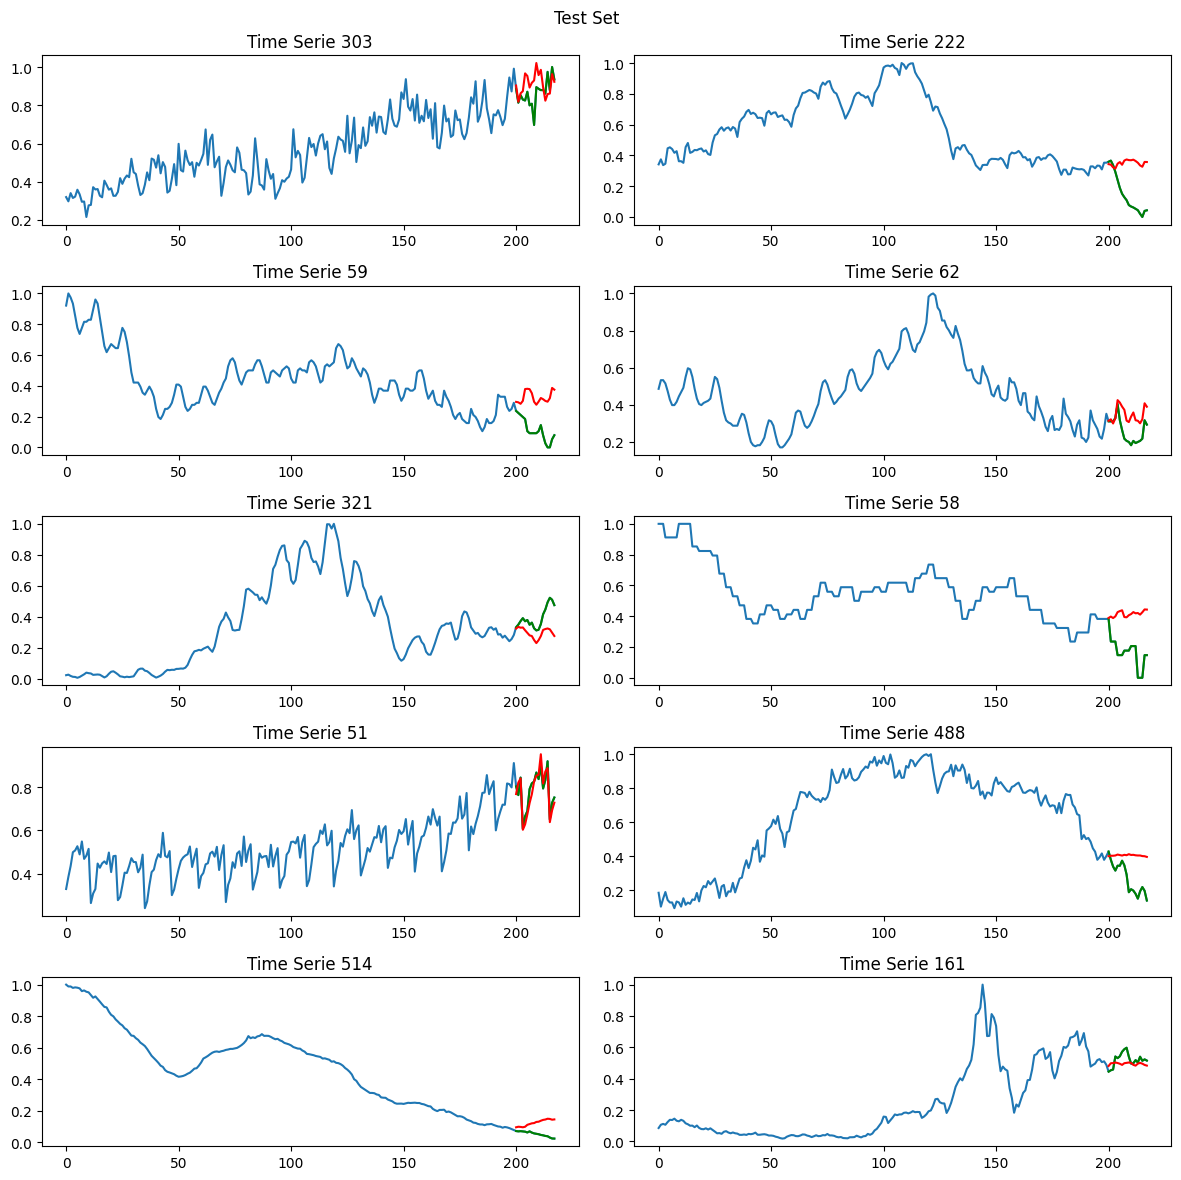

In [ ]:
# Create the figure and axes
figure, axes = plt.subplots(5, 2, figsize=(12, 12))

# Create an array filled with NaN values
empty = np.full((x_test.shape[0], 200), np.nan)

# Generate 2 random row indices
random_rows = random.sample(range(x_test.shape[0]), 10)

# Iterate through subplot grid
for i, ax in enumerate(axes.flatten()):
    row_index = random_rows[i]

    # Plot the original, green, and red lines with different line styles
    ax.plot(np.concatenate((x_test[row_index], y_test[row_index])))
    ax.plot(np.concatenate((empty[row_index], y_test[row_index])), color='green')
    ax.plot(np.concatenate((empty[row_index], out[row_index])), color='red')

    # Set the title
    ax.set_title(f'Time Serie {row_index}')

# Set the suptitle, adjust layout, and show the plot
plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

In [ ]:
model.save('oggi_1')

Here's why it is probably really important to identify with high precision the first time stamp:

In [ ]:
max_delta = np.argmax(abs(out[:,:1] - y_test[:,:1]))

out[max_delta,:1] - y_test[max_delta,:1]

array([-0.2393293])

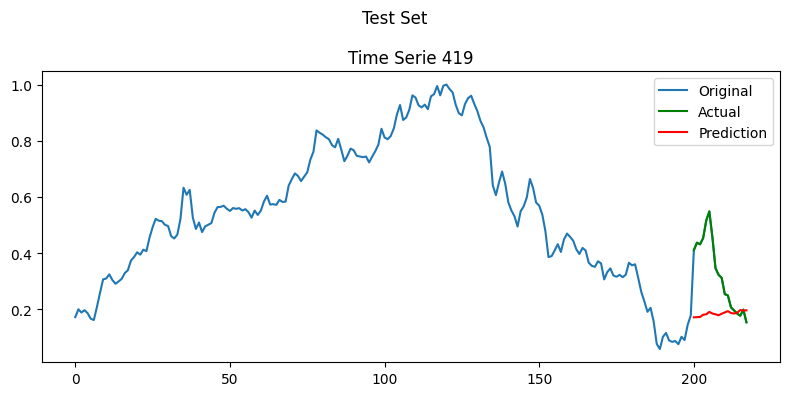

In [ ]:
# Create the figure and axes
figure, ax = plt.subplots(figsize=(8, 4))

# Create an array filled with NaN values
empty = np.full((x_test.shape[0], 200), np.nan)

# Choose the row index you want to plot
row_index = max_delta

# Plot the original, green, and red lines with different line styles
ax.plot(np.concatenate((x_test[row_index], y_test[row_index])), label='Original')
ax.plot(np.concatenate((empty[row_index], y_test[row_index])), label='Actual', color='green')
ax.plot(np.concatenate((empty[row_index], out[row_index])), label='Prediction', color='red')

# Set the title
ax.set_title(f'Time Serie {row_index}')

# Set legend, adjust layout, and show the plot
ax.legend()
plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

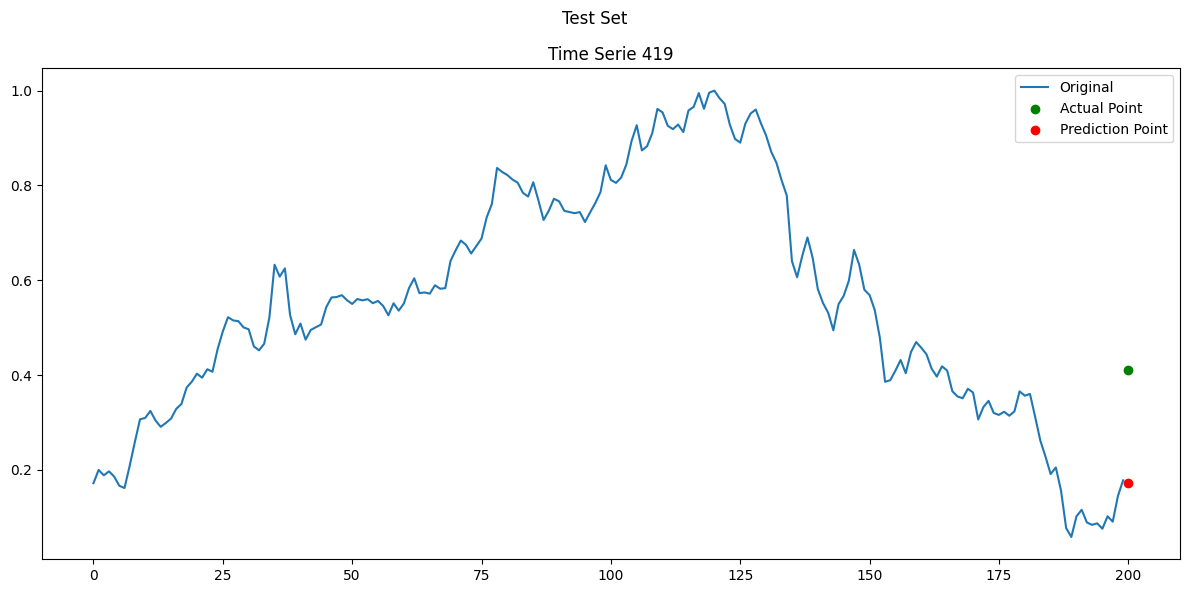

In [ ]:
# Create the figure and axes
figure, axes = plt.subplots(1, 1, figsize=(12, 6))

# Create an array filled with NaN values
empty = np.full((x_test.shape[0], 200), np.nan)

# Generate a random row index
row_index = max_delta

# Plot the original, green, and red lines with different line styles
axes.plot(x_test[row_index], label='Original', linestyle='-')

# Scatter plot for single points
axes.scatter(len(x_test[row_index]), y_test[row_index, :1], color='green', marker='o', label='Actual Point')
axes.scatter(len(empty[row_index]), out[row_index, :1], color='red', marker='o', label='Prediction Point')

# Set the title
axes.set_title(f'Time Serie {row_index}')

# Set the suptitle, adjust layout, and show the plot
plt.suptitle("Test Set")
axes.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test[:,:1] - out[:,:1]) ** 2)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.0016310765923572466


### Best Model

This is our model after the implementation of the attention mechanism:

In [ ]:
# Load arrays from file
data = np.load('Stride_218_float32.npz')

# Access the loaded arrays
x_train, y_train, x_val, y_val, x_test, y_test = data['x_train'], data['y_train'], data['x_val'], data['y_val'], data['x_test'], data['y_test']

In [ ]:
# Define the input layer
inputs = Input(shape=(200, 1))

# Apply Bidirectional LSTM
lstm_output = Bidirectional(LSTM(256, return_sequences=True))(inputs)

# Reshape to 3D for the Attention layer
lstm_output_reshaped = Reshape((-1, 2, 256))(lstm_output)

# Apply Attention layer with query and value inputs
attention_output = Attention()([lstm_output_reshaped, lstm_output_reshaped])

# Reshape back to 2D
attention_output_reshaped = Reshape((-1, 512))(attention_output)

# Apply Bidirectional LSTM on the attention output
lstm_output_2 = Bidirectional(LSTM(256))(attention_output_reshaped)

# Add the final dense layer
output = Dense(18)(lstm_output_2)

# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=32, callbacks=[
    EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.1, min_lr=1e-5)
])

# Evaluate the model on the test set
mse = model.evaluate(x_test, y_test)

# Make predictions
predictions = model.predict(x_test)

Epoch 1/200
1104/1104 [==============================] - 80s 58ms/step - loss: 0.0290 - val_loss: 0.0265 - lr: 0.0010
Epoch 2/200
1104/1104 [==============================] - 64s 58ms/step - loss: 0.0235 - val_loss: 0.0228 - lr: 0.0010
Epoch 3/200
1104/1104 [==============================] - 63s 57ms/step - loss: 0.0211 - val_loss: 0.0212 - lr: 0.0010
Epoch 4/200
1104/1104 [==============================] - 63s 57ms/step - loss: 0.0200 - val_loss: 0.0199 - lr: 0.0010
Epoch 5/200
1104/1104 [==============================] - 63s 57ms/step - loss: 0.0192 - val_loss: 0.0196 - lr: 0.0010
Epoch 6/200
1104/1104 [==============================] - 63s 57ms/step - loss: 0.0185 - val_loss: 0.0191 - lr: 0.0010
Epoch 7/200
1104/1104 [==============================] - 63s 57ms/step - loss: 0.0209 - val_loss: 0.0198 - lr: 0.0010
Epoch 8/200
1104/1104 [==============================] - 65s 59ms/step - loss: 0.0185 - val_loss: 0.0186 - lr: 0.0010
Epoch 9/200
1104/1104 [==============================] -

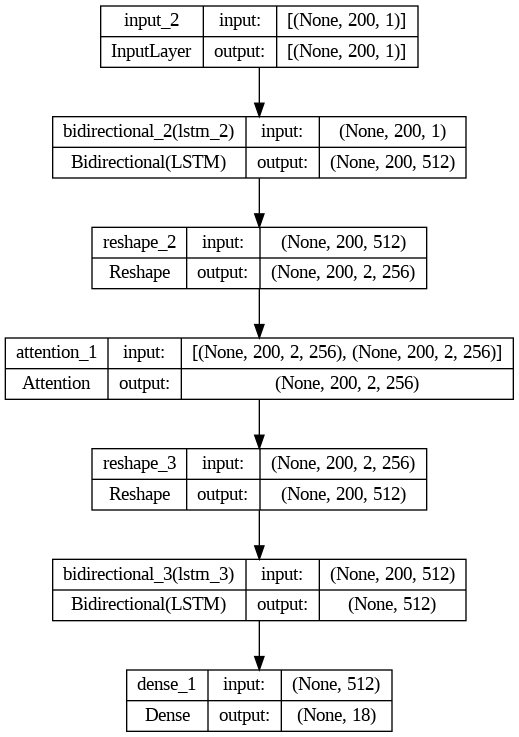

In [ ]:
from tensorflow.keras.utils import plot_model
# Optionally, plot the model graphically
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

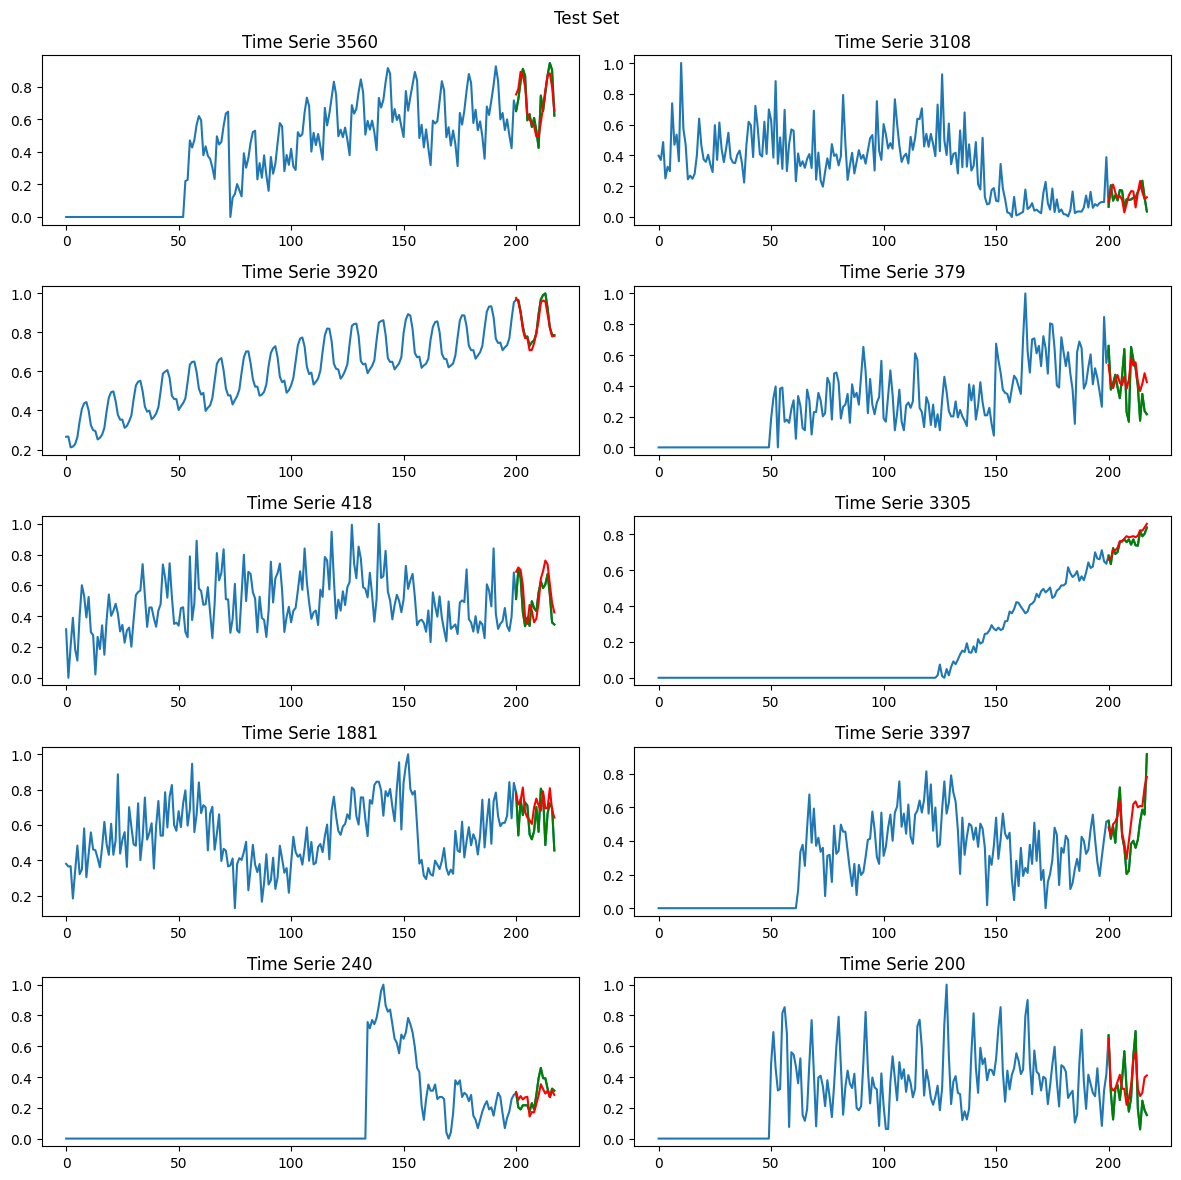

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(12, 12))

empty = np.zeros([x_test.shape[0], 200])
empty[empty == 0] = np.nan  # Set empty values to NaN

# Generate 2 random row indices
random_rows = random.sample(range(x_test.shape[0]), 10)

for i, row_index in enumerate(random_rows):
    row = i // 2
    col = i % 2
    axs[row, col].plot(np.concatenate((x_test[row_index], y_test[row_index])))
    axs[row, col].plot(np.concatenate((empty[row_index], y_test[row_index])), color='green')
    axs[row, col].plot(np.concatenate((empty[row_index], predictions[row_index])), color='red')
    axs[row, col].set_title(f'Time Serie {row_index}')

plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

In [ ]:
model.save("0.0126")

### Enhance Best Model by improving First Prediction

We tried to combine the model that performed best in CodaLab development by using a model that is trained to predict only the first time stamp.

Since it's the first time stamp only, the model is able to perform better than one that tries to generalise more and predict 18 time stamps.

It's obviously useless to exploit this model to predict the following timestamps since it would propagate the errors produced at the previous predictions.

In [ ]:
# Load arrays from file
data = np.load('Relevant_Patterns.npz')

# Access the loaded arrays
x_train, y_train, x_val, y_val, x_test, y_test = data['x_train'], data['y_train'], data['x_val'], data['y_val'], data['x_test'], data['y_test']

In [ ]:
# Load the best model
model18 = load_model("0.0126")

In [ ]:
# Define the LSTM model to predict only one sample
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(200, 1)))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
model.fit(x_train, y_train[:,:1], validation_data=(x_val, y_val[:,:1]), epochs=100, batch_size=32, callbacks = [
              tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=7, restore_best_weights=True),
              tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)
          ])

Epoch 1/100
512/512 [==============================] - 40s 53ms/step - loss: 0.0112 - val_loss: 0.0059 - lr: 0.0010
Epoch 2/100
512/512 [==============================] - 22s 43ms/step - loss: 0.0065 - val_loss: 0.0056 - lr: 0.0010
Epoch 3/100
512/512 [==============================] - 27s 52ms/step - loss: 0.0061 - val_loss: 0.0061 - lr: 0.0010
Epoch 4/100
512/512 [==============================] - 25s 49ms/step - loss: 0.0060 - val_loss: 0.0055 - lr: 0.0010
Epoch 5/100
512/512 [==============================] - 21s 42ms/step - loss: 0.0059 - val_loss: 0.0051 - lr: 0.0010
Epoch 6/100
512/512 [==============================] - 22s 43ms/step - loss: 0.0057 - val_loss: 0.0048 - lr: 0.0010
Epoch 7/100
512/512 [==============================] - 22s 43ms/step - loss: 0.0054 - val_loss: 0.0046 - lr: 0.0010
Epoch 8/100
512/512 [==============================] - 22s 44ms/step - loss: 0.0053 - val_loss: 0.0048 - lr: 0.0010
Epoch 9/100
512/512 [==============================] - 22s 42ms/step - l

In [ ]:
# Evaluate the model on the test set
mse = model.evaluate(x_test, y_test[:,:1])

# Make predictions
first_prediction = model.predict(x_test)

print("MSE on first prediction:", mse)

17/17 [==============================] - 2s 21ms/step
MSE on first prediction: 0.0017112286295741796


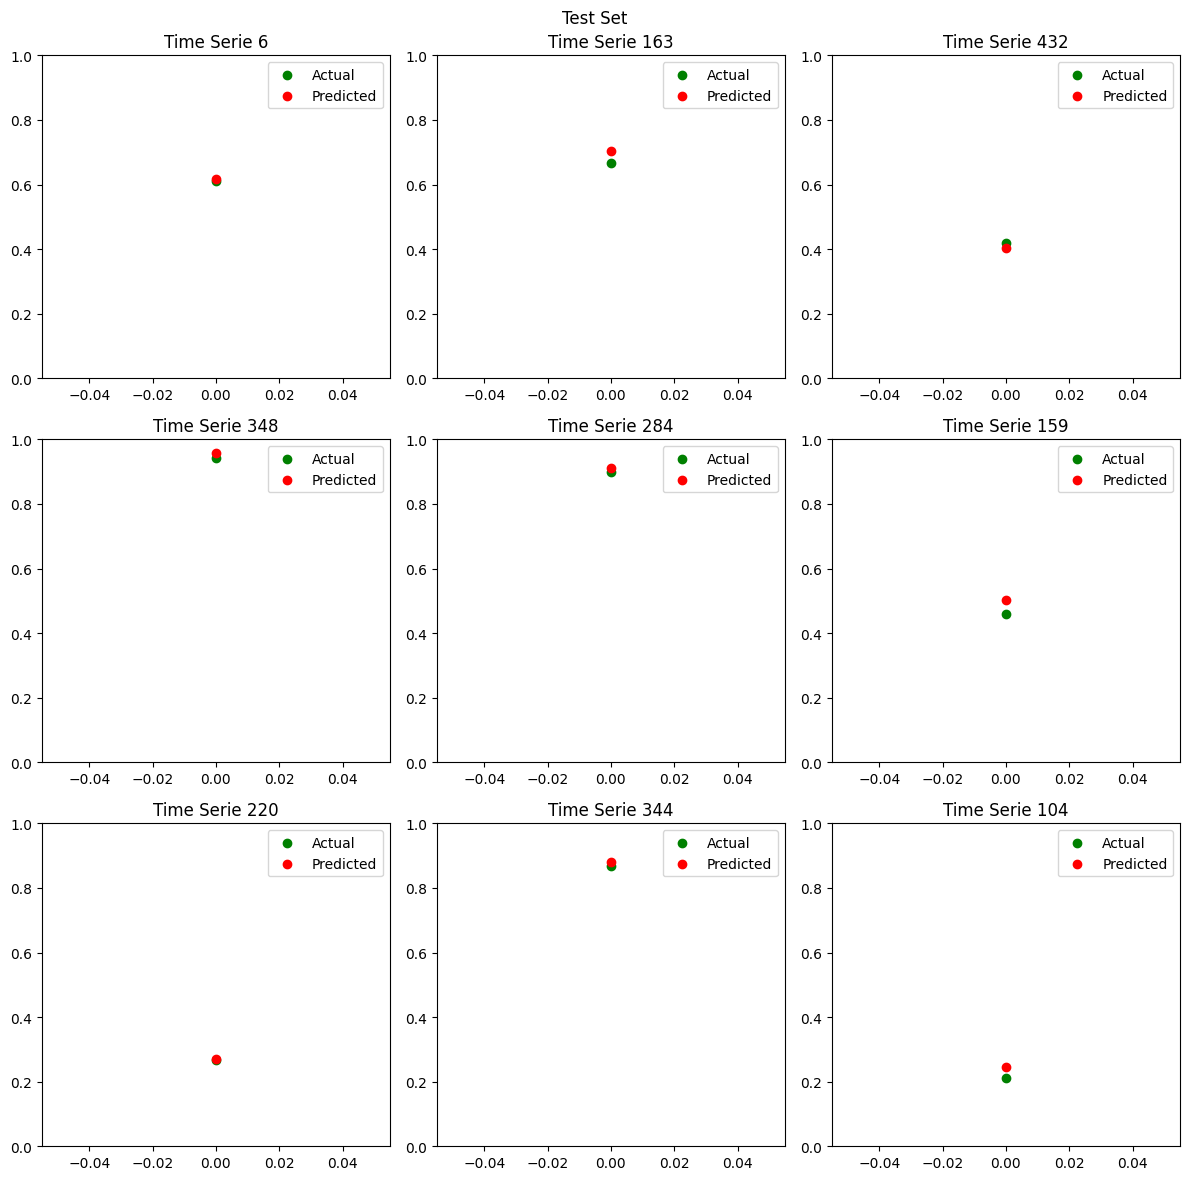

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

empty = np.zeros([x_test.shape[0], 200])
empty[empty == 0] = np.nan  # Set empty values to NaN

# Generate 9 random row indices
random_rows = random.sample(range(x_test.shape[0]), 9)

for i, row_index in enumerate(random_rows):
    row = i // 3
    col = i % 3
    axs[row, col].scatter([0], [y_test[row_index, 0]], color='green', label='Actual')
    axs[row, col].scatter([0], [first_prediction[row_index, 0]], color='red', label='Predicted')
    axs[row, col].set_title(f'Time Serie {row_index}')
    axs[row, col].set_ylim(0, 1)
    axs[row, col].legend()  # Add legend for clarity

plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

In [ ]:
prediction_one = model.predict(x_test)

# Make prediction
predictions_18 = model18.predict(x_test)

predictions = np.concatenate((prediction_one, predictions_18[:,1:]), axis=1)

# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test[:,:9] - predictions[:,:9])**2)

print("Mean Squared Error for 9 predictions:", mse)

# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test - predictions)**2)

print("Mean Squared Error for 18 predictions:", mse)

17/17 [==============================] - 1s 34ms/step
Mean Squared Error for 9 predictions: 0.006549307896610698
Mean Squared Error for 18 predictions: 0.011739600387899096


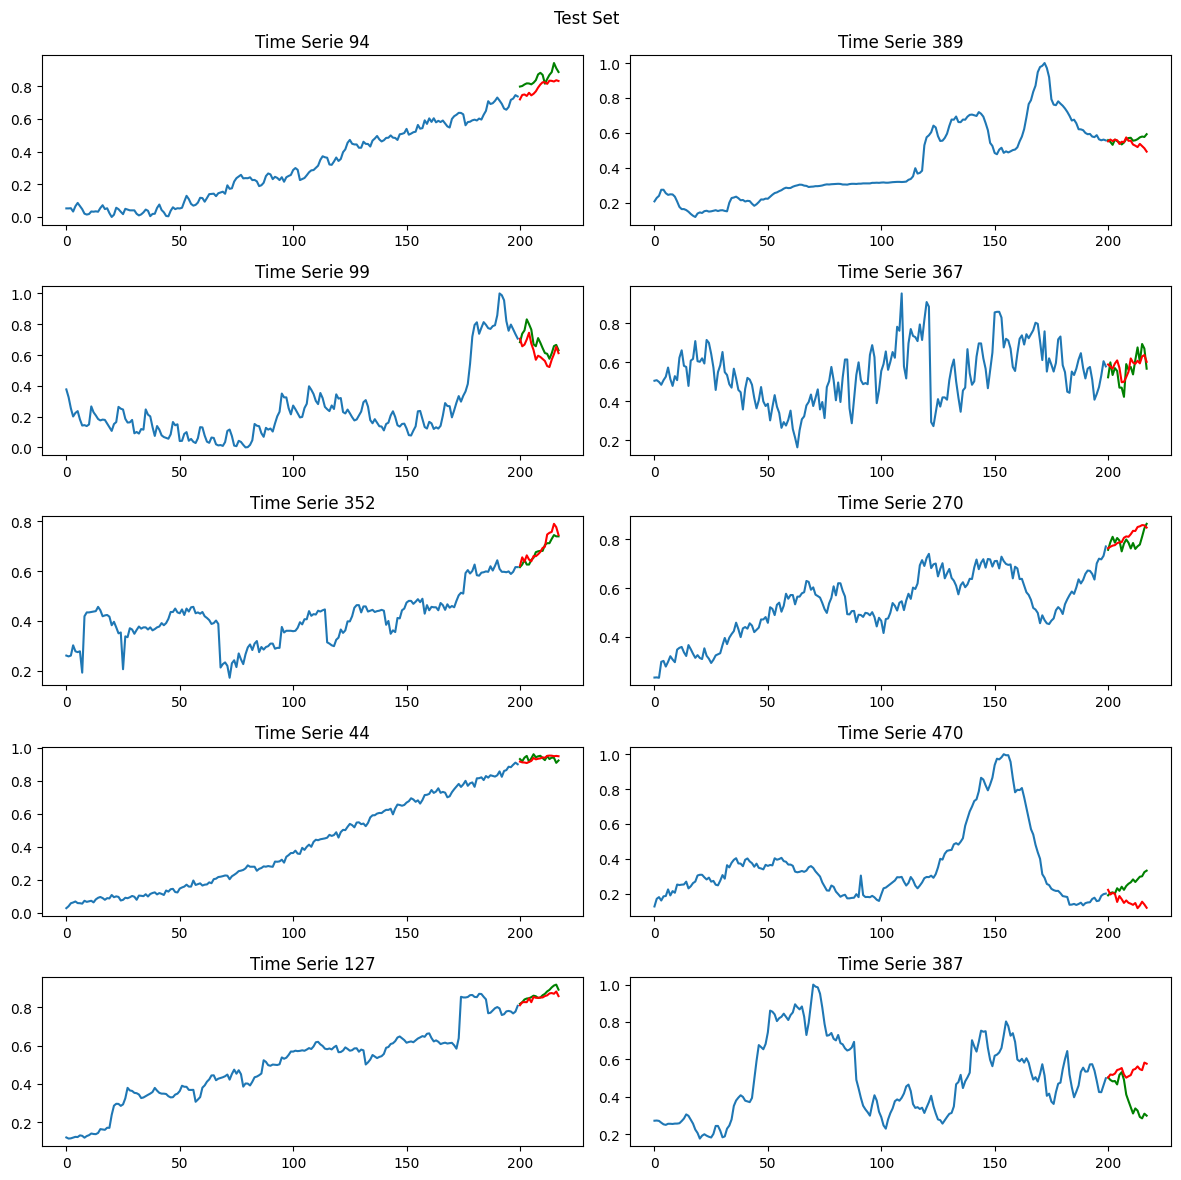

In [ ]:
# Create the figure and axes
figure, axes = plt.subplots(5, 2, figsize=(12, 12))

# Create an array filled with NaN values
empty = np.full((x_test.shape[0], 200), np.nan)

# Generate 2 random row indices
random_rows = random.sample(range(x_test.shape[0]), 10)

# Iterate through subplot grid
for i, ax in enumerate(axes.flatten()):
    row_index = random_rows[i]

    # Plot the original, green, and red lines with different line styles
    ax.plot(x_test[row_index])
    ax.plot(np.concatenate((empty[row_index], y_test[row_index])), color='green')
    ax.plot(np.concatenate((empty[row_index], predictions[row_index])), color='red')

  # Set the title
    ax.set_title(f'Time Serie {row_index}')

# Set the suptitle, adjust layout, and show the plot
plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

## Other Models
A list of all the models we tested with all different kinds of data throughout the challenge.

### Bidirectional LSTM From LAB

In [ ]:
# Load arrays from file
data = np.load('Stride_218.npz')

# Access the loaded arrays
x_train = data['x_train']
y_train = data['y_train']
x_val = data['x_val']
y_val = data['y_val']
x_test = data['x_test']
y_test = data['y_test']

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Reshape the input from (200,) to (200,1)
    input_layer = tfkl.Reshape((input_shape, 1))(input_layer)

    # Add a Bidirectional LSTM layer with 32 units
    x = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(1, 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    output_layer = tfkl.Reshape((output_shape,), name='reshape')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-3))

    return model

In [ ]:
model = build_CONV_LSTM_model(x_train.shape[1], y_train.shape[1])
model.summary()

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 64)           8704      
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 200, 128)          24704     
                                                                 
 output_layer (Conv1D)       (None, 200, 1)            385       
                                                                 
 cropping (Cropping1D)       (None, 18, 1)             0         
                                                                 
 reshape (Reshape)           (None, 18)                0         
                                                   

In [ ]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 100,
    validation_data=(x_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

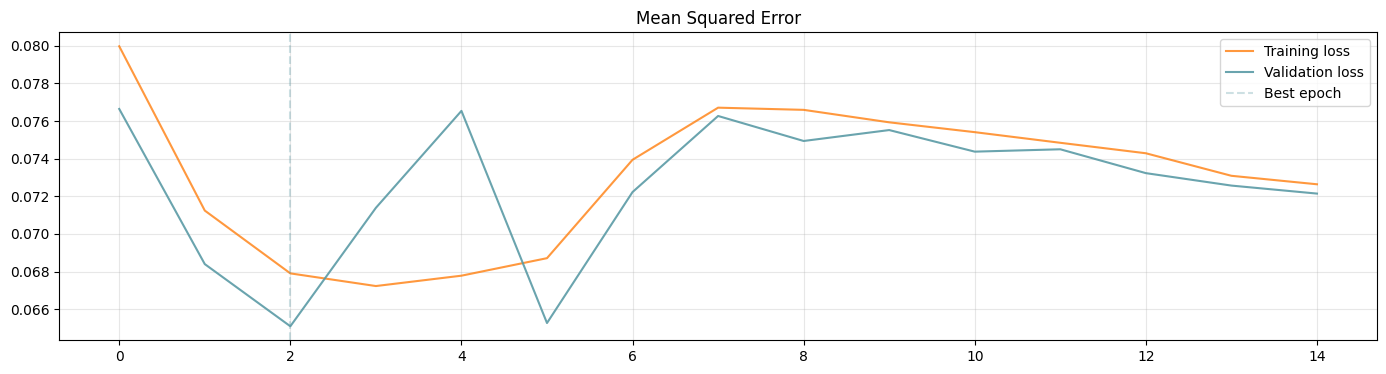

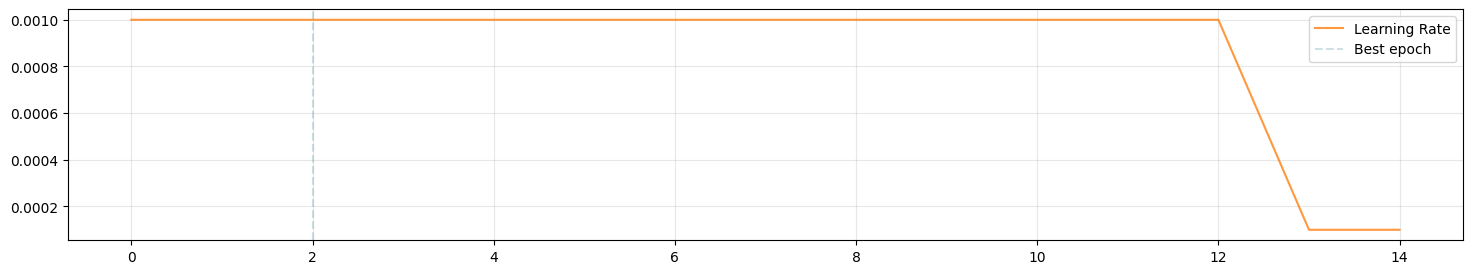

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

Test evaluation

In [ ]:
# Predict the test set using the model
predictions = model.predict(x_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (5234, 18)
Mean Squared Error: 0.060753874480724335
Mean Absolute Error: 0.20296184718608856


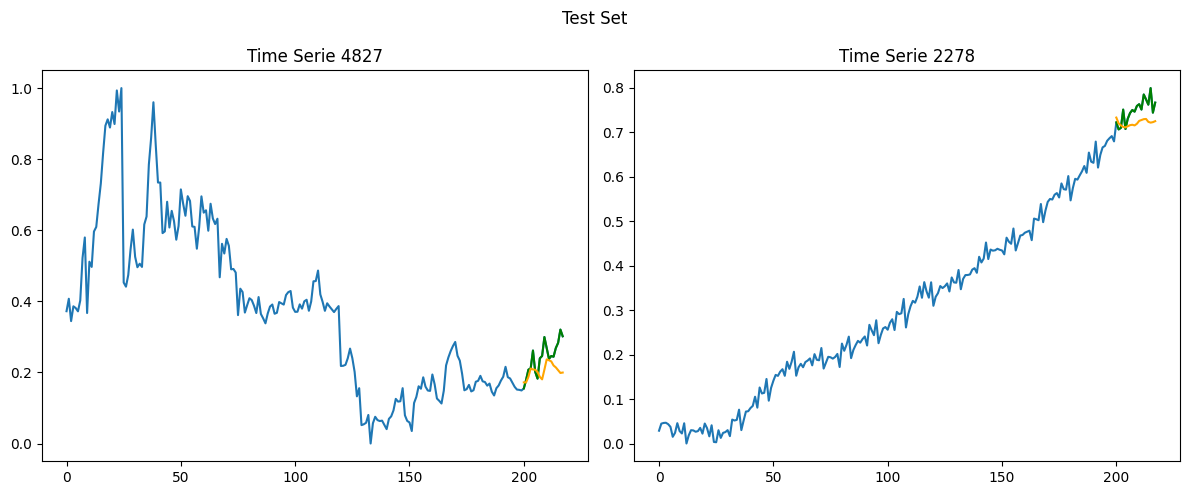

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

empty = np.zeros([x_test.shape[0], 200])
empty[empty == 0] = np.nan  # Set empty values to NaN

# Generate 2 random row indices
random_rows = random.sample(range(x_test.shape[0]), 2)

for i, row_index in enumerate(random_rows):
    col = i % 2
    axs[col].plot(np.concatenate((x_test[row_index], y_test[row_index])))
    axs[col].plot(np.concatenate((empty[row_index], y_test[row_index])), color='green')
    axs[col].plot(np.concatenate((empty[row_index], predictions[row_index])), color='orange')
    axs[col].set_title(f'Time Serie {row_index}')

plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

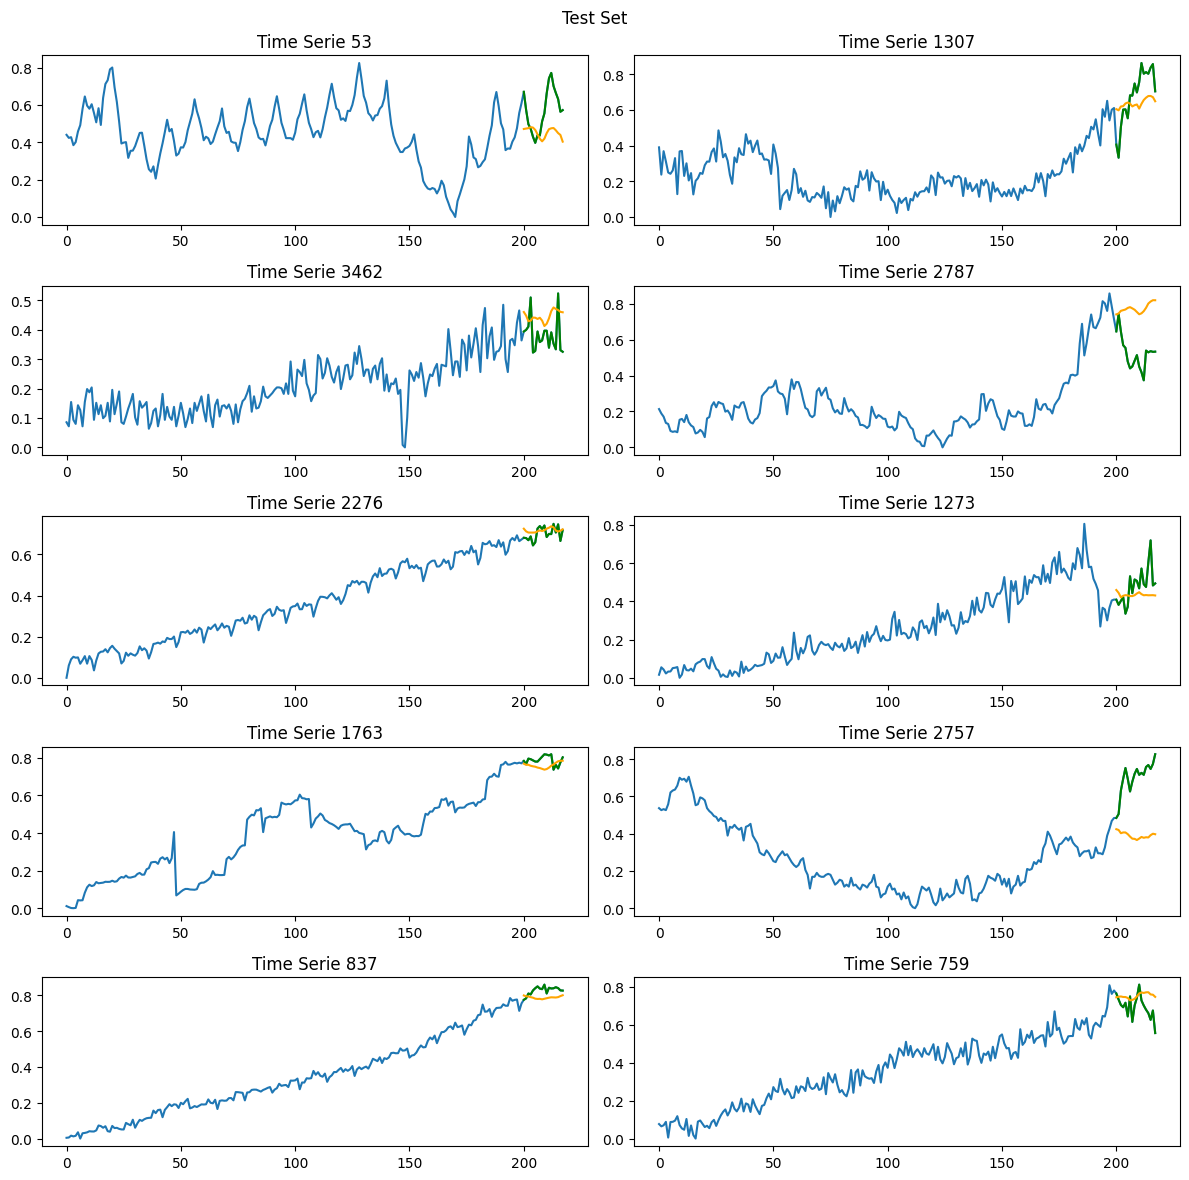

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(12, 12))

empty = np.zeros([x_test.shape[0], 200])
empty[empty == 0] = np.nan  # Set empty values to NaN

# Generate 2 random row indices
random_rows = random.sample(range(x_test.shape[0]), 10)

for i, row_index in enumerate(random_rows):
    row = i // 2
    col = i % 2
    axs[row, col].plot(np.concatenate((x_test[row_index], y_test[row_index])))
    axs[row, col].plot(np.concatenate((empty[row_index], y_test[row_index])), color='green')
    axs[row, col].plot(np.concatenate((empty[row_index], predictions[row_index])), color='orange')
    axs[row, col].set_title(f'Time Serie {row_index}')

plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

###Regularized baseline model

Here we tried to regularize with Ridge Regression to have less overfitting, but the results on the remote test set were worse

In [ ]:
# Define the BidirectionalLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=(200, 1)))
model.add(Bidirectional(LSTM(256), input_shape=(200, 1)))
model.add(Dense(18, kernel_regularizer=tf.keras.regularizers.l2(1e-4)))


# Compile the model
model.compile(optimizer=AdamW(learning_rate=1e-3), loss='mse')

# Train the model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=64, callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=True),
])

Epoch 1/200
552/552 [==============================] - 56s 89ms/step - loss: 0.0302 - val_loss: 0.0240
Epoch 2/200
552/552 [==============================] - 48s 87ms/step - loss: 0.0226 - val_loss: 0.0225
Epoch 3/200
552/552 [==============================] - 47s 86ms/step - loss: 0.0217 - val_loss: 0.0226
Epoch 4/200
552/552 [==============================] - 48s 87ms/step - loss: 0.0208 - val_loss: 0.0210
Epoch 5/200
552/552 [==============================] - 47s 86ms/step - loss: 0.0198 - val_loss: 0.0203
Epoch 6/200
552/552 [==============================] - 48s 87ms/step - loss: 0.0192 - val_loss: 0.0201
Epoch 7/200
552/552 [==============================] - 48s 87ms/step - loss: 0.0189 - val_loss: 0.0195
Epoch 8/200
552/552 [==============================] - 48s 87ms/step - loss: 0.0185 - val_loss: 0.0188
Epoch 9/200
552/552 [==============================] - 48s 86ms/step - loss: 0.0181 - val_loss: 0.0191
Epoch 10/200
552/552 [==============================] - 48s 87ms/step - l

In [ ]:
# Predict the test set using the model
predictions = model.predict(x_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (4010, 18)
Mean Squared Error: 0.013798396103084087
Mean Absolute Error: 0.07725599408149719


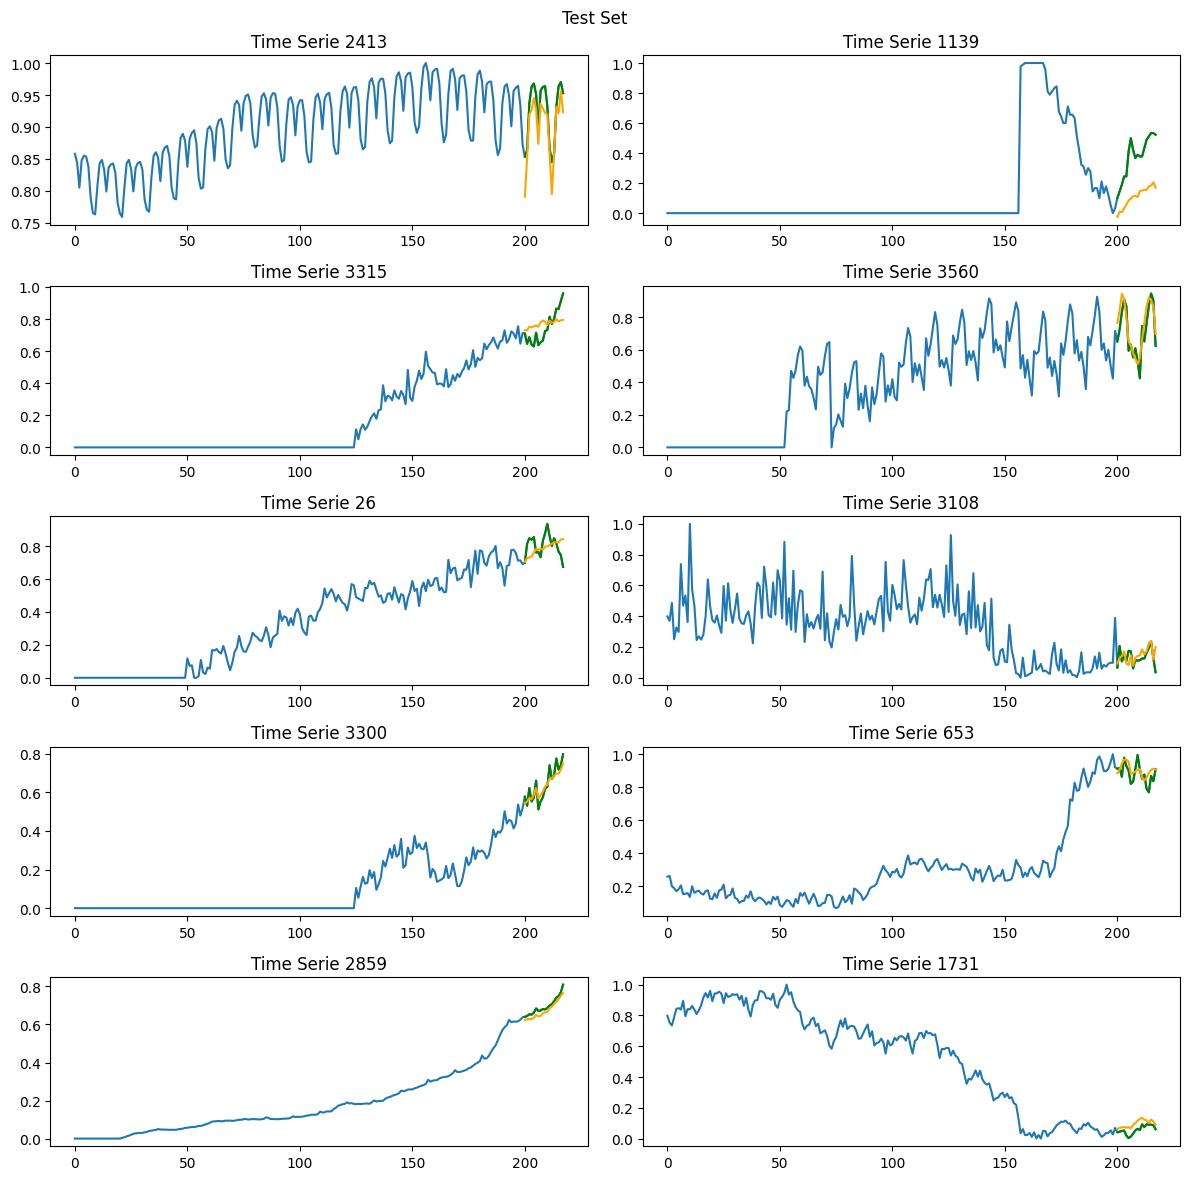

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(12, 12))

empty = np.zeros([x_test.shape[0], 200])
empty[empty == 0] = np.nan  # Set empty values to NaN

# Generate 2 random row indices
random_rows = random.sample(range(x_test.shape[0]), 10)

for i, row_index in enumerate(random_rows):
    row = i // 2
    col = i % 2
    axs[row, col].plot(np.concatenate((x_test[row_index], y_test[row_index])))
    axs[row, col].plot(np.concatenate((empty[row_index], y_test[row_index])), color='green')
    axs[row, col].plot(np.concatenate((empty[row_index], predictions[row_index])), color='orange')
    axs[row, col].set_title(f'Time Serie {row_index}')

plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

### Multi Head Attention

This is a version of the model with a Multi Head Attention layer, key_dim = 256 and two heads

In [ ]:
earlyStopping = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=True)
reduceLr = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)

In [ ]:
# Define the input layer with shape (200, 1)
inputs = tfkl.Input(shape=(200,1))

# Add Bidirectional LSTM layers
lstm_in = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences = True), input_shape=(200,1))(inputs)

# Add attention mechanism
attention_mech = tfkl.MultiHeadAttention(num_heads=2, key_dim=256)(inputs, lstm_in)

# Add Bidirectional LSTM layers
lstm_out = tfkl.Bidirectional(LSTM(256), input_shape=(200, 1))(attention_mech)



# Output layer for time series forecasting
outputs = tfkl.Dense(18,kernel_regularizer=tf.keras.regularizers.L2(0.001))(lstm_out)

In [ ]:
model = tfk.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_12 (Bidirect  (None, 200, 512)             528384    ['input_7[0][0]']             
 ional)                                                                                           
                                                                                                  
 multi_head_attention_6 (Mu  (None, 200, 1)               526849    ['input_7[0][0]',             
 ltiHeadAttention)                                                   'bidirectional_12[0][0]']    
                                                                                            

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=32,
    callbacks=[earlyStopping,reduceLr],
    validation_data = (X_val, y_val)
    ).history

Epoch 1/200
512/512 [==============================] - 41s 48ms/step - loss: 0.0514 - val_loss: 0.0184 - lr: 0.0010
Epoch 2/200
512/512 [==============================] - 23s 45ms/step - loss: 0.0148 - val_loss: 0.0133 - lr: 0.0010
Epoch 3/200
512/512 [==============================] - 24s 47ms/step - loss: 0.0147 - val_loss: 0.0128 - lr: 0.0010
Epoch 4/200
512/512 [==============================] - 24s 47ms/step - loss: 0.0133 - val_loss: 0.0124 - lr: 0.0010
Epoch 5/200
512/512 [==============================] - 24s 46ms/step - loss: 0.0129 - val_loss: 0.0119 - lr: 0.0010
Epoch 6/200
512/512 [==============================] - 24s 46ms/step - loss: 0.0127 - val_loss: 0.0118 - lr: 0.0010
Epoch 7/200
512/512 [==============================] - 24s 46ms/step - loss: 0.0127 - val_loss: 0.0128 - lr: 0.0010
Epoch 8/200
512/512 [==============================] - 25s 48ms/step - loss: 0.0126 - val_loss: 0.0115 - lr: 0.0010
Epoch 9/200
512/512 [==============================] - 24s 46ms/step - l

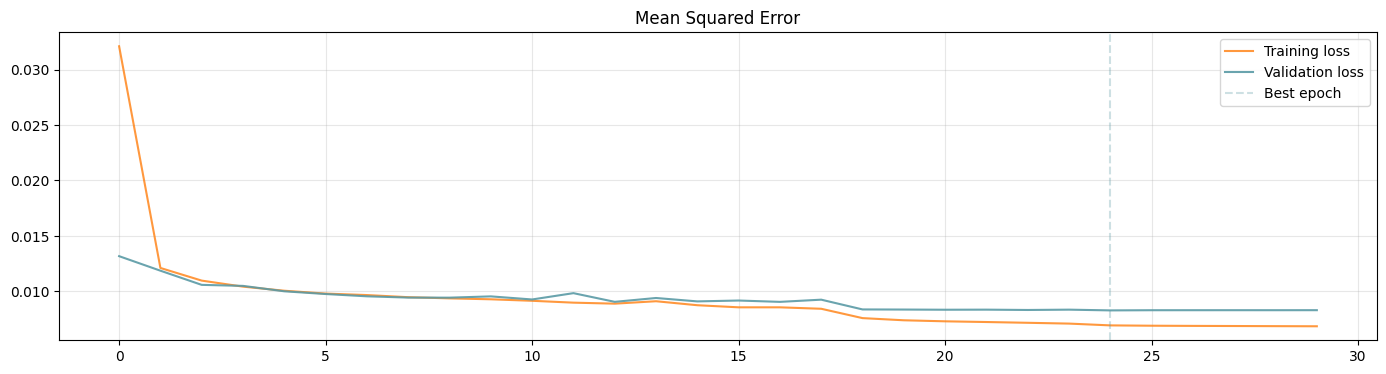

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (2412, 18)
Mean Squared Error: 0.007931557483971119
Mean Absolute Error: 0.05731791630387306


In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test[:,:9].flatten(), predictions[:,:9].flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test[:,:9].flatten(), predictions[:,:9].flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

#0.005201892461627722 ltsm 256
#0.005131757818162441 lstm 256 attention 64
#0.004941082559525967 lstm 256 attention 128

Predictions shape: (2412, 18)
Mean Squared Error: 0.005905366502702236
Mean Absolute Error: 0.04729972779750824


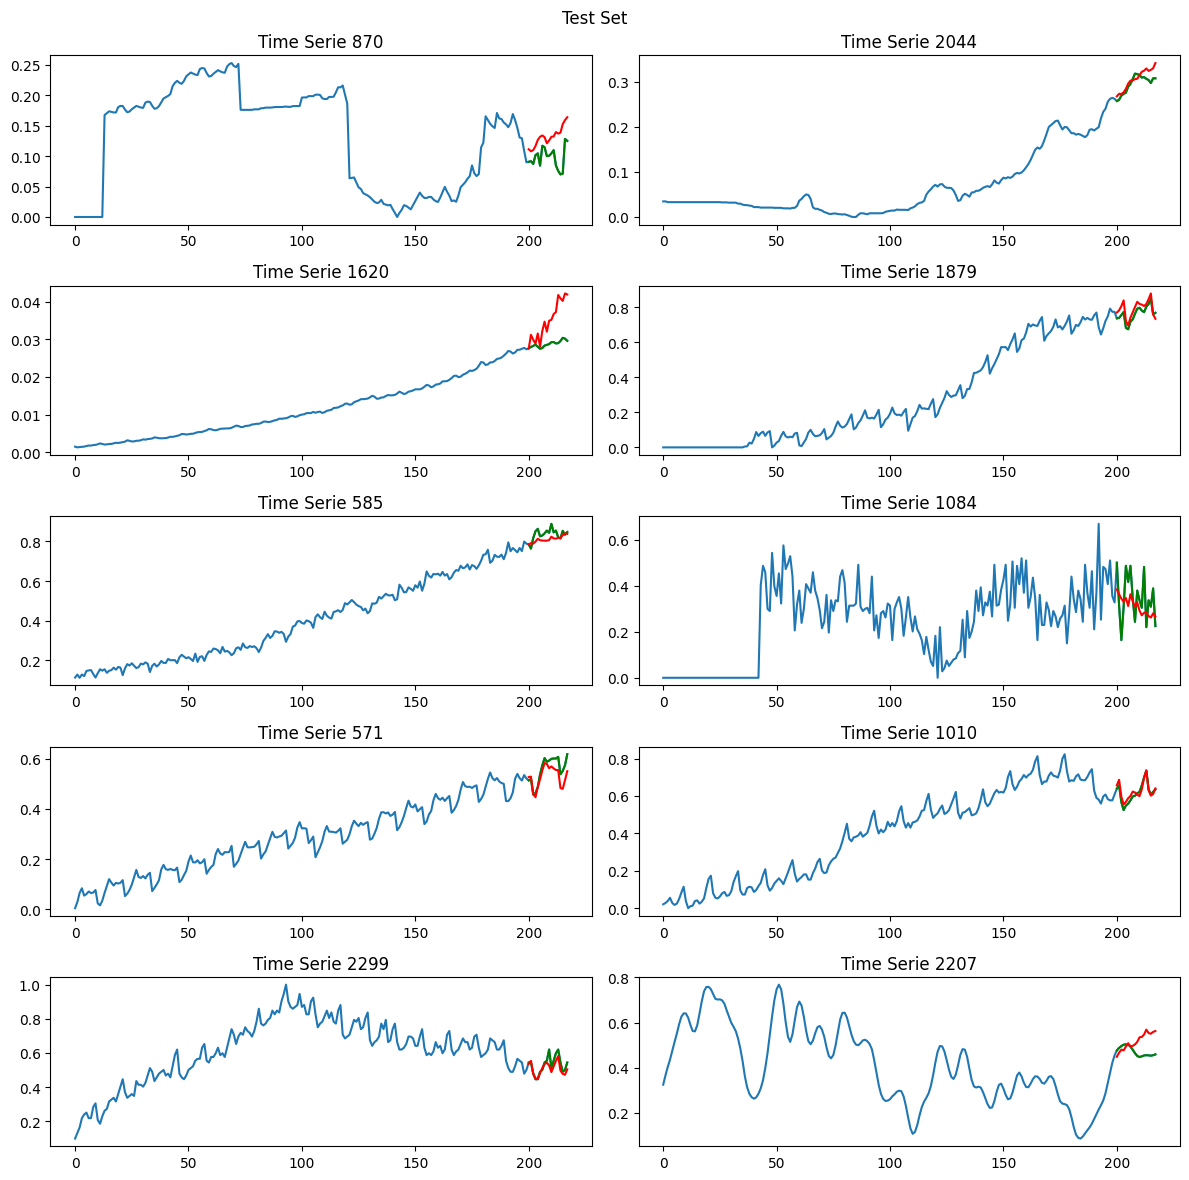

In [ ]:
# Create the figure and axes
figure, axes = plt.subplots(5, 2, figsize=(12, 12))

# Create an array filled with NaN values
empty = np.full((X_test.shape[0], 200), np.nan)

# Generate 2 random row indices
random_rows = random.sample(range(X_test.shape[0]), 10)

# Iterate through subplot grid
for i, ax in enumerate(axes.flatten()):
    row_index = random_rows[i]

    # Plot the original, green, and red lines with different line styles
    ax.plot(np.concatenate((X_test[row_index], y_test[row_index])))
    ax.plot(np.concatenate((empty[row_index], y_test[row_index])), color='green')
    ax.plot(np.concatenate((empty[row_index], predictions[row_index])), color='red')

    # Set the title
    ax.set_title(f'Time Serie {row_index}')

# Set the suptitle, adjust layout, and show the plot
plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

### 2 prediction

In [ ]:
# Load arrays from file
data = np.load('Stride_218_NO-Zero_padding.npz')

# Access the loaded arrays
x_train, y_train, x_val, y_val, x_test, y_test = data['x_train'], data['y_train'], data['x_val'], data['y_val'], data['x_test'], data['y_test']

In [ ]:
# Load the models
model = load_model("Second_prediction_up")
model18 = load_model("0.0126")

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(200, 1)))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(2))

# Compile the model
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
model.fit(x_train, y_train[:,:2], validation_data=(x_val, y_val[:,:2]), epochs=100, batch_size=32, callbacks = [
              tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=7, restore_best_weights=True),
              tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)
          ])

Epoch 1/100
574/574 [==============================] - 39s 54ms/step - loss: 0.0095 - val_loss: 0.0078 - lr: 0.0010
Epoch 2/100
574/574 [==============================] - 26s 46ms/step - loss: 0.0061 - val_loss: 0.0062 - lr: 0.0010
Epoch 3/100
574/574 [==============================] - 27s 48ms/step - loss: 0.0056 - val_loss: 0.0060 - lr: 0.0010
Epoch 4/100
574/574 [==============================] - 26s 46ms/step - loss: 0.0057 - val_loss: 0.0053 - lr: 0.0010
Epoch 5/100
574/574 [==============================] - 27s 46ms/step - loss: 0.0053 - val_loss: 0.0052 - lr: 0.0010
Epoch 6/100
574/574 [==============================] - 27s 47ms/step - loss: 0.0048 - val_loss: 0.0048 - lr: 0.0010
Epoch 7/100
574/574 [==============================] - 27s 47ms/step - loss: 0.0046 - val_loss: 0.0048 - lr: 0.0010
Epoch 8/100
574/574 [==============================] - 25s 44ms/step - loss: 0.0046 - val_loss: 0.0052 - lr: 0.0010
Epoch 9/100
574/574 [==============================] - 27s 46ms/step - l

In [ ]:
# Evaluate the model on the test set
mse = model.evaluate(x_test, y_test[:,:2])

# Make predictions
first_predictions = model.predict(x_test)

print("MSE on first 2 predictions:", mse)

17/17 [==============================] - 1s 12ms/step
MSE on first 2 predictions: 0.002030937699601054


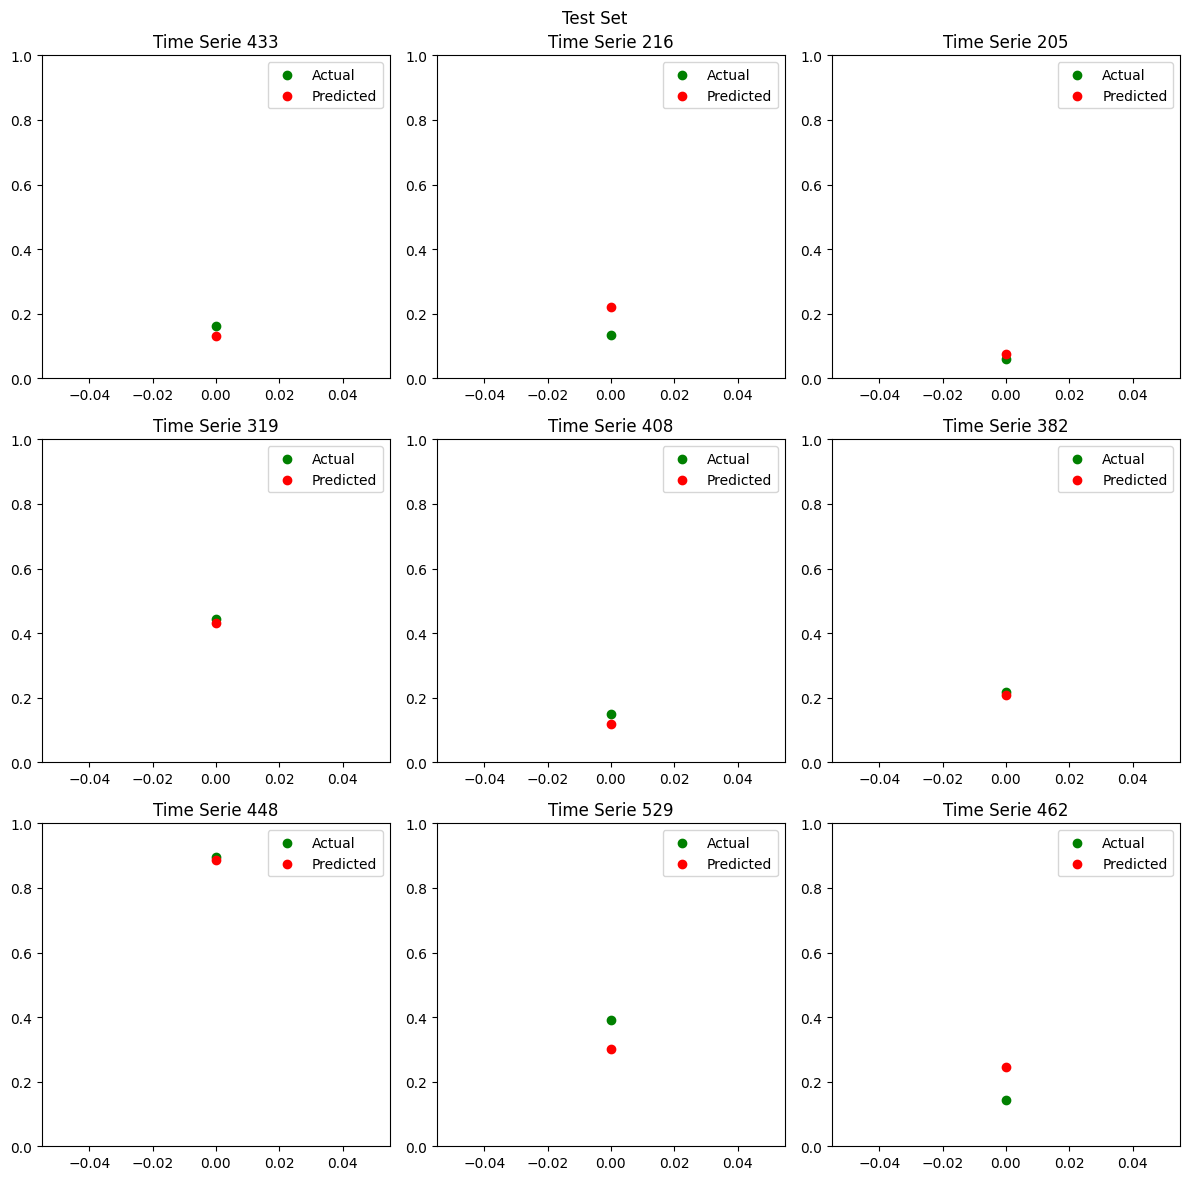

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

empty = np.zeros([x_test.shape[0], 200])
empty[empty == 0] = np.nan  # Set empty values to NaN

# Generate 9 random row indices
random_rows = random.sample(range(x_test.shape[0]), 9)

for i, row_index in enumerate(random_rows):
    row = i // 3
    col = i % 3
    axs[row, col].scatter([0], [y_test[row_index, 1]], color='green', label='Actual')
    axs[row, col].scatter([0], [first_predictions[row_index, 1]], color='red', label='Predicted')
    axs[row, col].set_title(f'Time Serie {row_index}')
    axs[row, col].set_ylim(0, 1)
    axs[row, col].legend()  # Add legend for clarity

plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

In [ ]:
predictions_two = model.predict(x_test)

# Make prediction
predictions_18 = model18.predict(x_test)

predictions = np.concatenate((predictions_two, predictions_18[:,2:]), axis=1)

# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test[:,:9] - predictions[:,:9])**2)

print("Mean Squared Error for 9 predictions:", mse)

# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test - predictions)**2)

print("Mean Squared Error for 18 predictions:", mse)

17/17 [==============================] - 29s 1s/step
Mean Squared Error for 9 predictions: 0.006579805836169572
Mean Squared Error for 18 predictions: 0.0117548473464666


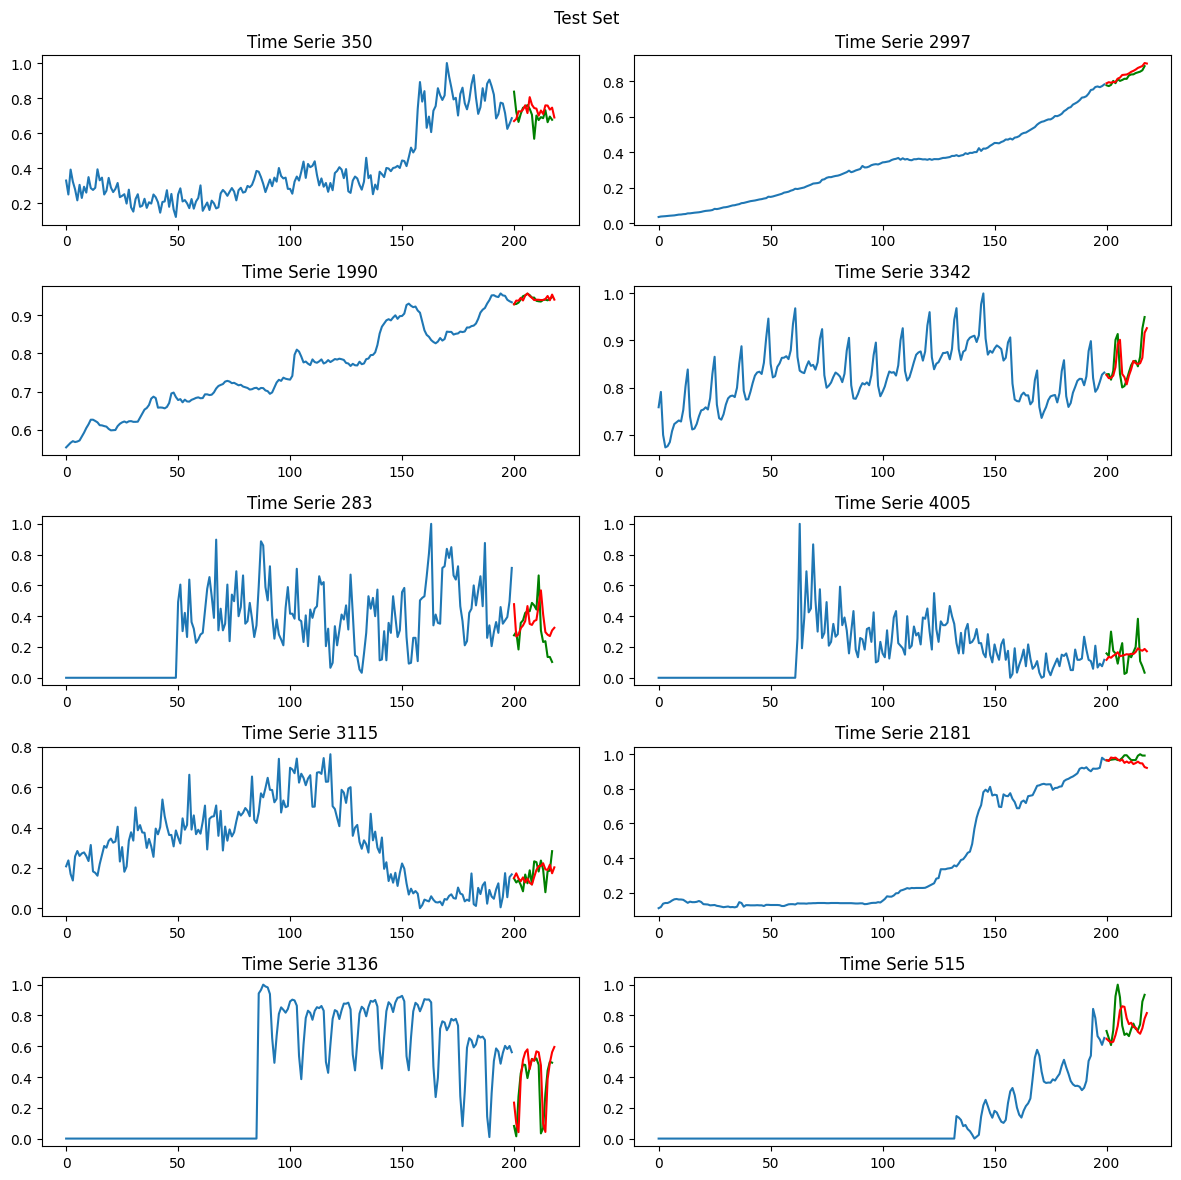

In [ ]:
# Create the figure and axes
figure, axes = plt.subplots(5, 2, figsize=(12, 12))

# Create an array filled with NaN values
empty = np.full((x_test.shape[0], 200), np.nan)

# Generate 2 random row indices
random_rows = random.sample(range(x_test.shape[0]), 10)

# Iterate through subplot grid
for i, ax in enumerate(axes.flatten()):
    row_index = random_rows[i]

    # Plot the original, green, and red lines with different line styles
    ax.plot(x_test[row_index])
    ax.plot(np.concatenate((empty[row_index], y_test[row_index])), color='green')
    ax.plot(np.concatenate((empty[row_index], predictions[row_index])), color='red')

    # Set the title
    ax.set_title(f'Time Serie {row_index}')

# Set the suptitle, adjust layout, and show the plot
plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

In [ ]:
# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test[:,1:2] - predictions_two[:,1:2])**2)

print(mse)

mse = np.mean((y_test[:,1:2] - predictions_18[:,1:2])**2)

print(mse)

0.03019689884381675
0.02923656237557296


In [ ]:
# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test[:,:1] - predictions_two[:,:1])**2)

print(mse)

mse = np.mean((y_test[:,:1] - predictions_18[:,:1])**2)

print(mse)

0.028912209180920242
0.02937932209291914


In [ ]:
prediction_one = model1.predict(x_test)

predictions_two = model.predict(x_test)

# Make prediction
predictions_18 = model18.predict(x_test)

predictions = np.concatenate((prediction_one, predictions_18[:,1:]), axis=1)

# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test[:,:9] - predictions[:,:9])**2)

print("Mean Squared Error for 9 predictions:", mse)

# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test - predictions)**2)

print("Mean Squared Error for 18 predictions:", mse)

17/17 [==============================] - 0s 19ms/step
Mean Squared Error for 9 predictions: 0.005256719691924558
Mean Squared Error for 18 predictions: 0.008522484709414573


In [ ]:
predictions_two = model.predict(x_test)

# Make prediction
predictions_18 = model18.predict(x_test)

predictions = np.concatenate((predictions_18[:,:1], predictions_two[:,1:2], predictions_18[:,2:]), axis=1)

# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test[:,:9] - predictions[:,:9])**2)

print("Mean Squared Error for 9 predictions:", mse)

# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test - predictions)**2)

print("Mean Squared Error for 18 predictions:", mse)

17/17 [==============================] - 0s 19ms/step
Mean Squared Error for 9 predictions: 0.005163047228948705
Mean Squared Error for 18 predictions: 0.008475648477926647


In [ ]:
mse = np.mean((y_test - predictions_18)**2)
mse

0.008527978207750062

In [ ]:
# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test - predictions_18)**2)
mse

0.008527978207750062

In [ ]:
model.save("Second_prediction_up")

### 3 prediction

In [ ]:
# Load arrays from file
data = np.load('Relevant_Patterns.npz')

# Access the loaded arrays
x_train, y_train, x_val, y_val, x_test, y_test = data['x_train'], data['y_train'], data['x_val'], data['y_val'], data['x_test'], data['y_test']

In [ ]:
# Load the models
# model = load_model("uno1")
model18 = load_model("boh_relevant1")

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(200, 1)))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(3))

# Compile the model
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
model.fit(x_train, y_train[:,:3], validation_data=(x_val, y_val[:,:3]), epochs=100, batch_size=32, callbacks = [
              tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=7, restore_best_weights=True),
              tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)
          ])

Epoch 1/100
512/512 [==============================] - 37s 52ms/step - loss: 0.0124 - val_loss: 0.0086 - lr: 0.0010
Epoch 2/100
512/512 [==============================] - 25s 49ms/step - loss: 0.0074 - val_loss: 0.0061 - lr: 0.0010
Epoch 3/100
512/512 [==============================] - 24s 47ms/step - loss: 0.0068 - val_loss: 0.0060 - lr: 0.0010
Epoch 4/100
512/512 [==============================] - 27s 52ms/step - loss: 0.0066 - val_loss: 0.0058 - lr: 0.0010
Epoch 5/100
512/512 [==============================] - 23s 45ms/step - loss: 0.0065 - val_loss: 0.0056 - lr: 0.0010
Epoch 6/100
512/512 [==============================] - 24s 47ms/step - loss: 0.0064 - val_loss: 0.0056 - lr: 0.0010
Epoch 7/100
512/512 [==============================] - 23s 45ms/step - loss: 0.0063 - val_loss: 0.0055 - lr: 0.0010
Epoch 8/100
512/512 [==============================] - 26s 52ms/step - loss: 0.0061 - val_loss: 0.0056 - lr: 0.0010
Epoch 9/100
512/512 [==============================] - 24s 47ms/step - l

In [ ]:
# Evaluate the model on the test set
mse = model.evaluate(x_test, y_test[:,:3])

# Make predictions
first_predictions = model.predict(x_test)

print("MSE on first 2 predictions:", mse)

17/17 [==============================] - 1s 11ms/step
MSE on first 2 predictions: 0.003354777116328478


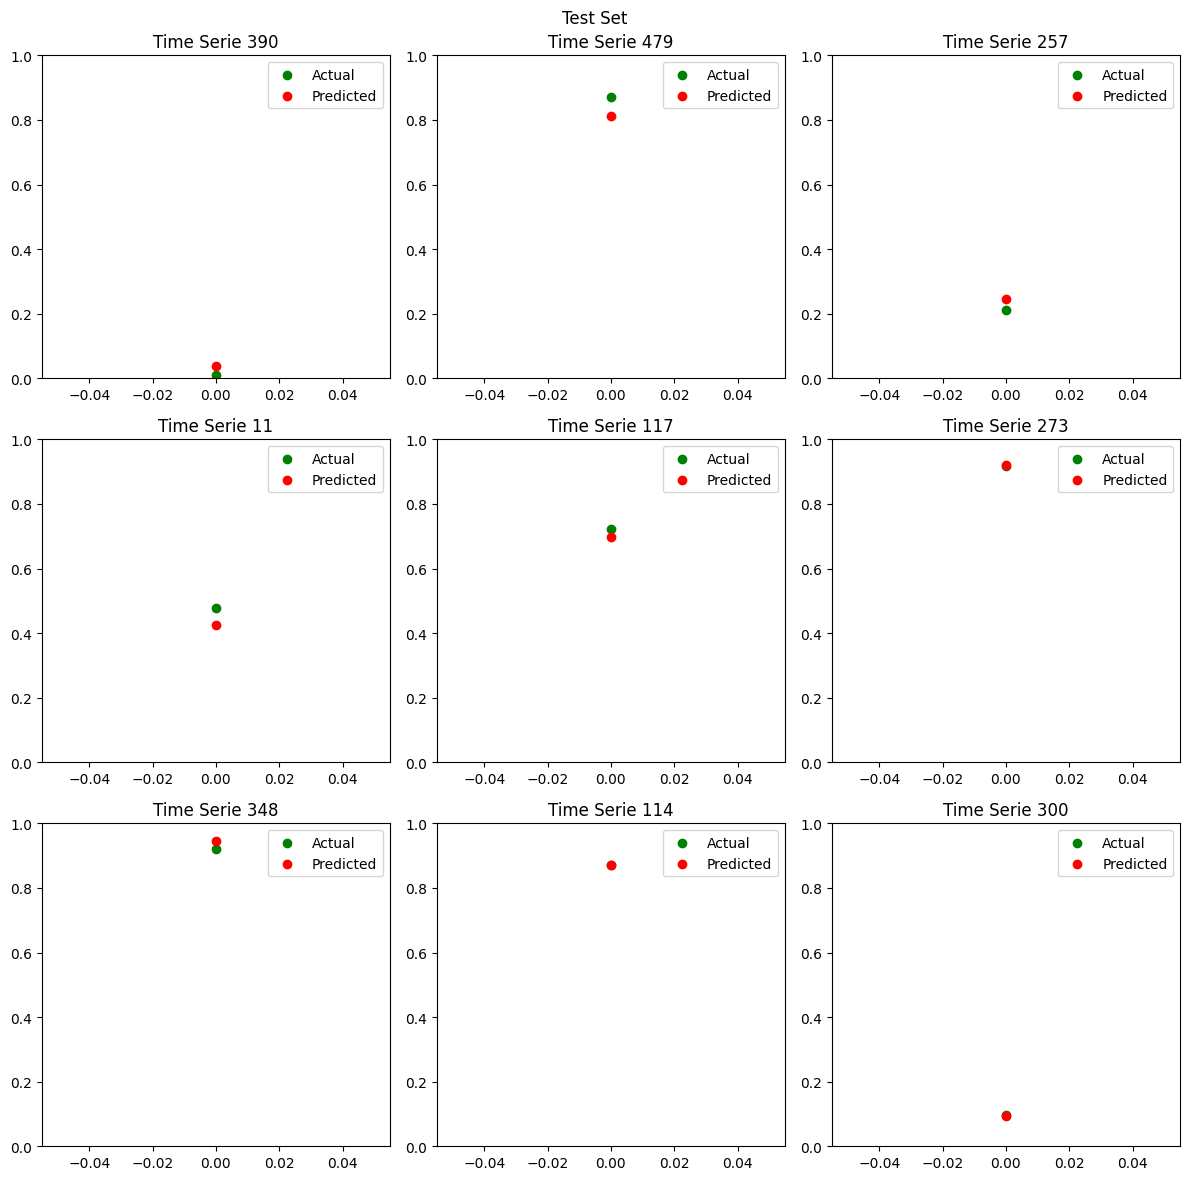

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

empty = np.zeros([x_test.shape[0], 200])
empty[empty == 0] = np.nan  # Set empty values to NaN

# Generate 9 random row indices
random_rows = random.sample(range(x_test.shape[0]), 9)

for i, row_index in enumerate(random_rows):
    row = i // 3
    col = i % 3
    axs[row, col].scatter([0], [y_test[row_index, 2]], color='green', label='Actual')
    axs[row, col].scatter([0], [first_predictions[row_index, 2]], color='red', label='Predicted')
    axs[row, col].set_title(f'Time Serie {row_index}')
    axs[row, col].set_ylim(0, 1)
    axs[row, col].legend()  # Add legend for clarity

plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

In [ ]:
predictions_3 = model.predict(x_test)

# Make prediction
predictions_18 = model18.predict(x_test)

predictions = np.concatenate((predictions_3, predictions_18[:,3:]), axis=1)

# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test[:,:9] - predictions[:,:9])**2)

print("Mean Squared Error for 9 predictions:", mse)

# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test - predictions)**2)

print("Mean Squared Error for 18 predictions:", mse)

17/17 [==============================] - 1s 52ms/step
Mean Squared Error for 9 predictions: 0.005635757742807129
Mean Squared Error for 18 predictions: 0.009509344327557127


In [ ]:
model1 = load_model("uno1")

prediction_one = model1.predict(x_test)

# predictions_two = model2.predict(x_test)

predictions_3 = model.predict(x_test)

# Make prediction
predictions_18 = model18.predict(x_test)

predictions = np.concatenate((prediction_one, predictions_two[:,1:2], predictions_3[:,2:3], predictions_18[:,3:]), axis=1)

# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test[:,:9] - predictions[:,:9])**2)

print("Mean Squared Error for 9 predictions:", mse)

# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test - predictions)**2)

print("Mean Squared Error for 18 predictions:", mse)

17/17 [==============================] - 1s 49ms/step
Mean Squared Error for 9 predictions: 0.005548830164056615
Mean Squared Error for 18 predictions: 0.00946588053818187


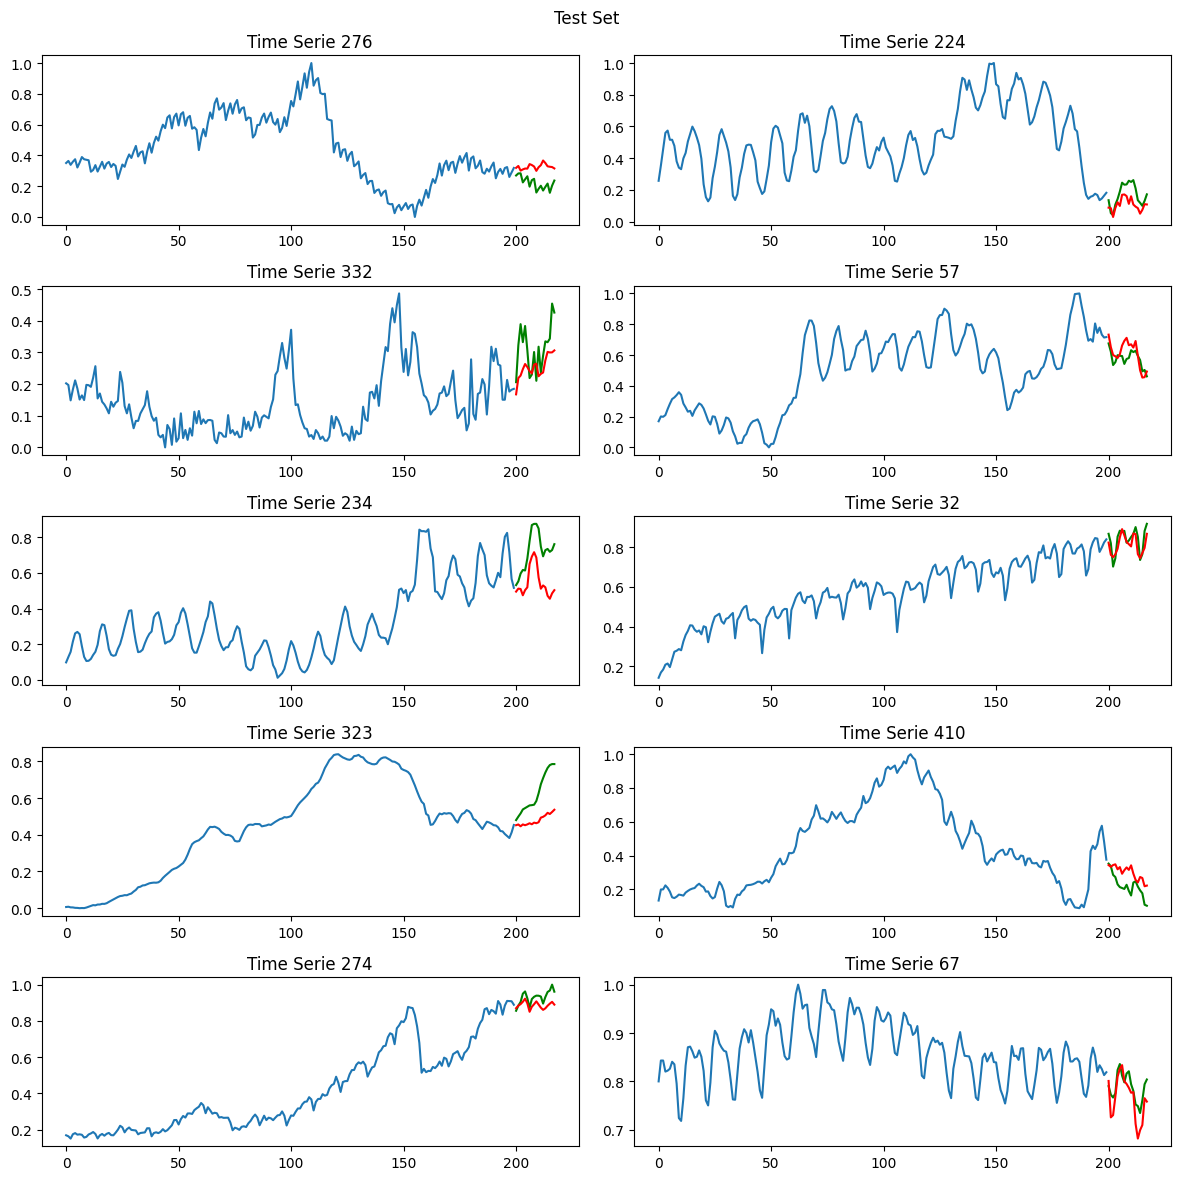

In [ ]:
# Create the figure and axes
figure, axes = plt.subplots(5, 2, figsize=(12, 12))

# Create an array filled with NaN values
empty = np.full((x_test.shape[0], 200), np.nan)

# Generate 2 random row indices
random_rows = random.sample(range(x_test.shape[0]), 10)

# Iterate through subplot grid
for i, ax in enumerate(axes.flatten()):
    row_index = random_rows[i]

    # Plot the original, green, and red lines with different line styles
    ax.plot(x_test[row_index])
    ax.plot(np.concatenate((empty[row_index], y_test[row_index])), color='green')
    ax.plot(np.concatenate((empty[row_index], predictions[row_index])), color='red')

    # Set the title
    ax.set_title(f'Time Serie {row_index}')

# Set the suptitle, adjust layout, and show the plot
plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

In [ ]:
# Load the models
model1 = load_model("uno1")
model18 = load_model("boh_relevant1")

In [ ]:
predictions_two = model.predict(x_test)

prediction_one = model1.predict(x_test)

predictions_18 = model18.predict(x_test)

# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test[:,:1] - prediction_one)**2)

print(mse)

mse = np.mean((y_test[:,:1] - predictions_two[:,:1])**2)

print(mse)

mse = np.mean((y_test[:,:1] - predictions_18[:,:1])**2)

print(mse)

17/17 [==============================] - 3s 57ms/step
0.0017112285918041074
0.0017525953663877524
0.002526514073522466


In [ ]:
# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test[:,2:3] - predictions_3[:,2:3])**2)

print(mse)

mse = np.mean((y_test[:,2:3] - predictions_18[:,2:3])**2)

print(mse)

0.004396521464422853
0.004212538946501836


So not worth

In [ ]:
prediction_one = model1.predict(x_test)

predictions_3 = model.predict(x_test)

# Make prediction
predictions_18 = model18.predict(x_test)

predictions = np.concatenate((prediction_one, predictions_3[:,1:3], predictions_18[:,3:]), axis=1)

# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test[:,:9] - predictions[:,:9])**2)

print("Mean Squared Error for 9 predictions:", mse)

# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test - predictions)**2)

print("Mean Squared Error for 18 predictions:", mse)

17/17 [==============================] - 1s 53ms/step
Mean Squared Error for 9 predictions: 0.0055637227124744615
Mean Squared Error for 18 predictions: 0.009473326812390792


In [ ]:
model.save("Second_prediction")

### Feedforward Neural Network

In [ ]:
# Load arrays from file
data = np.load('Stride_218.npz')

# Access the loaded arrays
x_train, y_train, x_val, y_val, x_test, y_test = data['x_train'], data['y_train'], data['x_val'], data['y_val'], data['x_test'], data['y_test']

In [ ]:
inputs = Input(shape=(x_train.shape[1],))
x = Dense(1024, activation='relu')(inputs)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(18)(x)
model = Model(inputs=inputs, outputs=x)

# Compile the model
model.compile(optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-3), loss='mse')

# Train the model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=32, callbacks = [
              tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True),
              tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.1, min_lr=1e-5)
          ])

# Evaluate the model on the test set
mse = model.evaluate(x_test, y_test)

# Make predictions
predictions = model.predict(x_test)

In [ ]:
# Evaluate the model on the test set
mse = model.evaluate(x_test, y_test)

# Make predictions
predictions = model.predict(x_test)

164/164 [==============================] - 0s 2ms/step


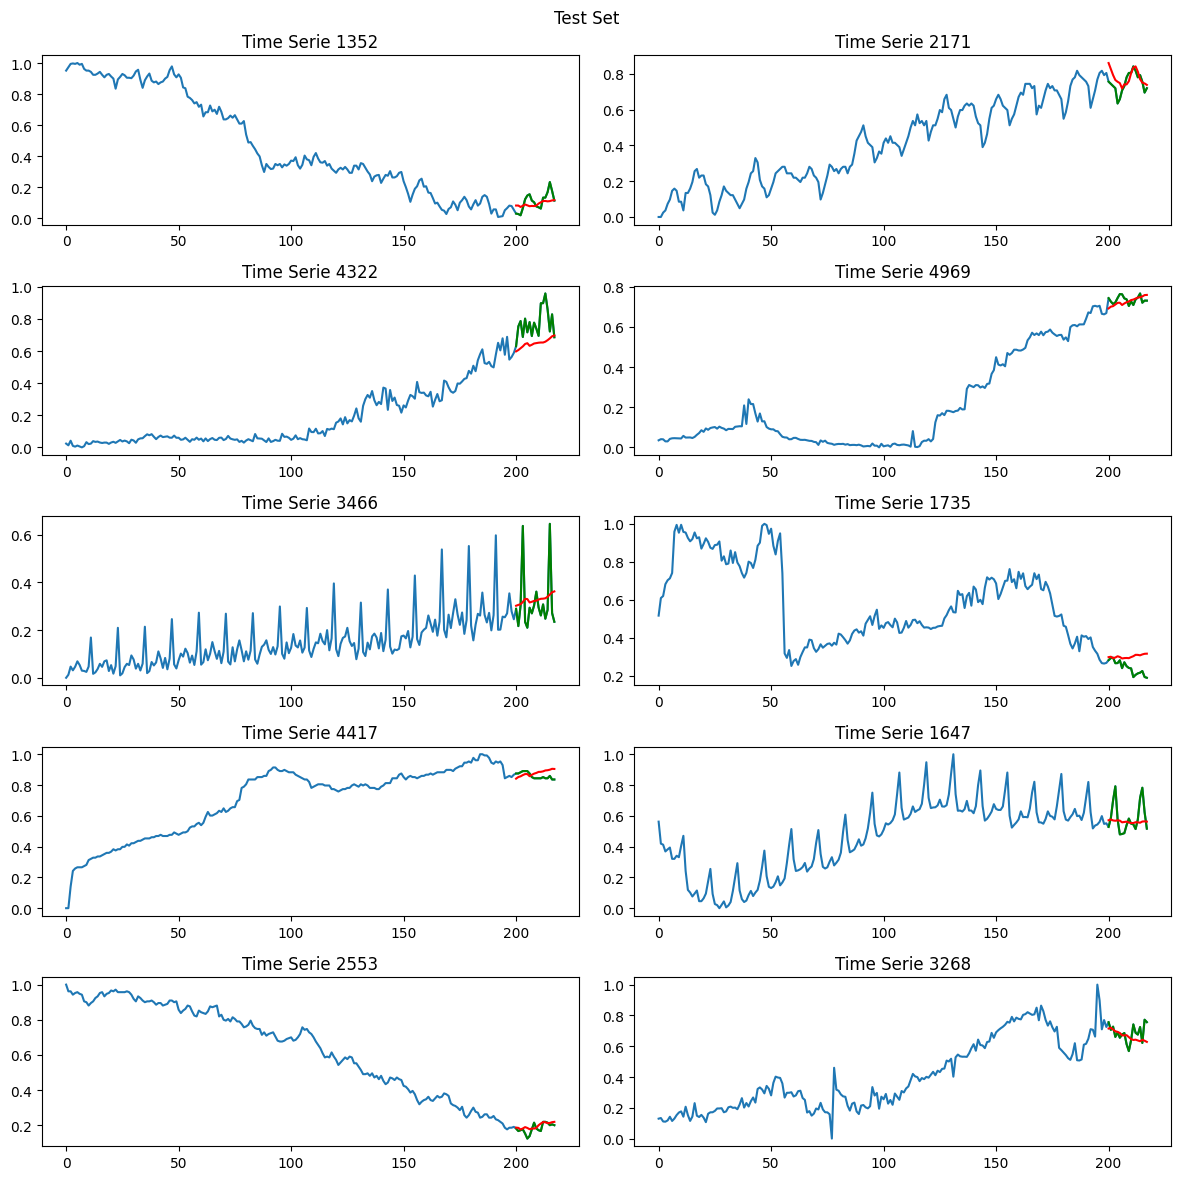

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(12, 12))

empty = np.zeros([x_test.shape[0], 200])
empty[empty == 0] = np.nan  # Set empty values to NaN

# Generate 2 random row indices
random_rows = random.sample(range(x_test.shape[0]), 10)

for i, row_index in enumerate(random_rows):
    row = i // 2
    col = i % 2
    axs[row, col].plot(np.concatenate((x_test[row_index], y_test[row_index])))
    axs[row, col].plot(np.concatenate((empty[row_index], y_test[row_index])), color='green')
    axs[row, col].plot(np.concatenate((empty[row_index], predictions[row_index])), color='red')
    axs[row, col].set_title(f'Time Serie {row_index}')

plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

### GRU

In [ ]:
# Load arrays from file
data = np.load('Stride_218.npz')

# Access the loaded arrays
x_train, y_train, x_val, y_val, x_test, y_test = data['x_train'], data['y_train'], data['x_val'], data['y_val'], data['x_test'], data['y_test']

In [ ]:
model = Sequential()
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
model.add(GRU(128, input_shape=(200, 1)))

model.add(Dense(18))

# Compile the model
model.compile(optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-3), loss='mse')

# Train the model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=32, callbacks = [
              tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True),
              tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.1, min_lr=1e-5)
          ])

# Evaluate the model on the test set
mse = model.evaluate(x_test, y_test)

# Make predictions
predictions = model.predict(x_test)

Epoch 1/200
1202/1202 [==============================] - 17s 12ms/step - loss: 0.0296 - val_loss: 0.0230 - lr: 0.0010
Epoch 2/200
1202/1202 [==============================] - 12s 10ms/step - loss: 0.0225 - val_loss: 0.0209 - lr: 0.0010
Epoch 3/200
1202/1202 [==============================] - 12s 10ms/step - loss: 0.0208 - val_loss: 0.0203 - lr: 0.0010
Epoch 4/200
1202/1202 [==============================] - 13s 11ms/step - loss: 0.0201 - val_loss: 0.0194 - lr: 0.0010
Epoch 5/200
1202/1202 [==============================] - 12s 10ms/step - loss: 0.0192 - val_loss: 0.0187 - lr: 0.0010
Epoch 6/200
1202/1202 [==============================] - 11s 9ms/step - loss: 0.0186 - val_loss: 0.0180 - lr: 0.0010
Epoch 7/200
1202/1202 [==============================] - 12s 10ms/step - loss: 0.0181 - val_loss: 0.0181 - lr: 0.0010
Epoch 8/200
1202/1202 [==============================] - 12s 10ms/step - loss: 0.0177 - val_loss: 0.0177 - lr: 0.0010
Epoch 9/200
1202/1202 [==============================] - 

In [ ]:
# Evaluate the model on the test set
mse = model.evaluate(x_test, y_test)

# Make predictions
predictions = model.predict(x_test)

164/164 [==============================] - 9s 40ms/step


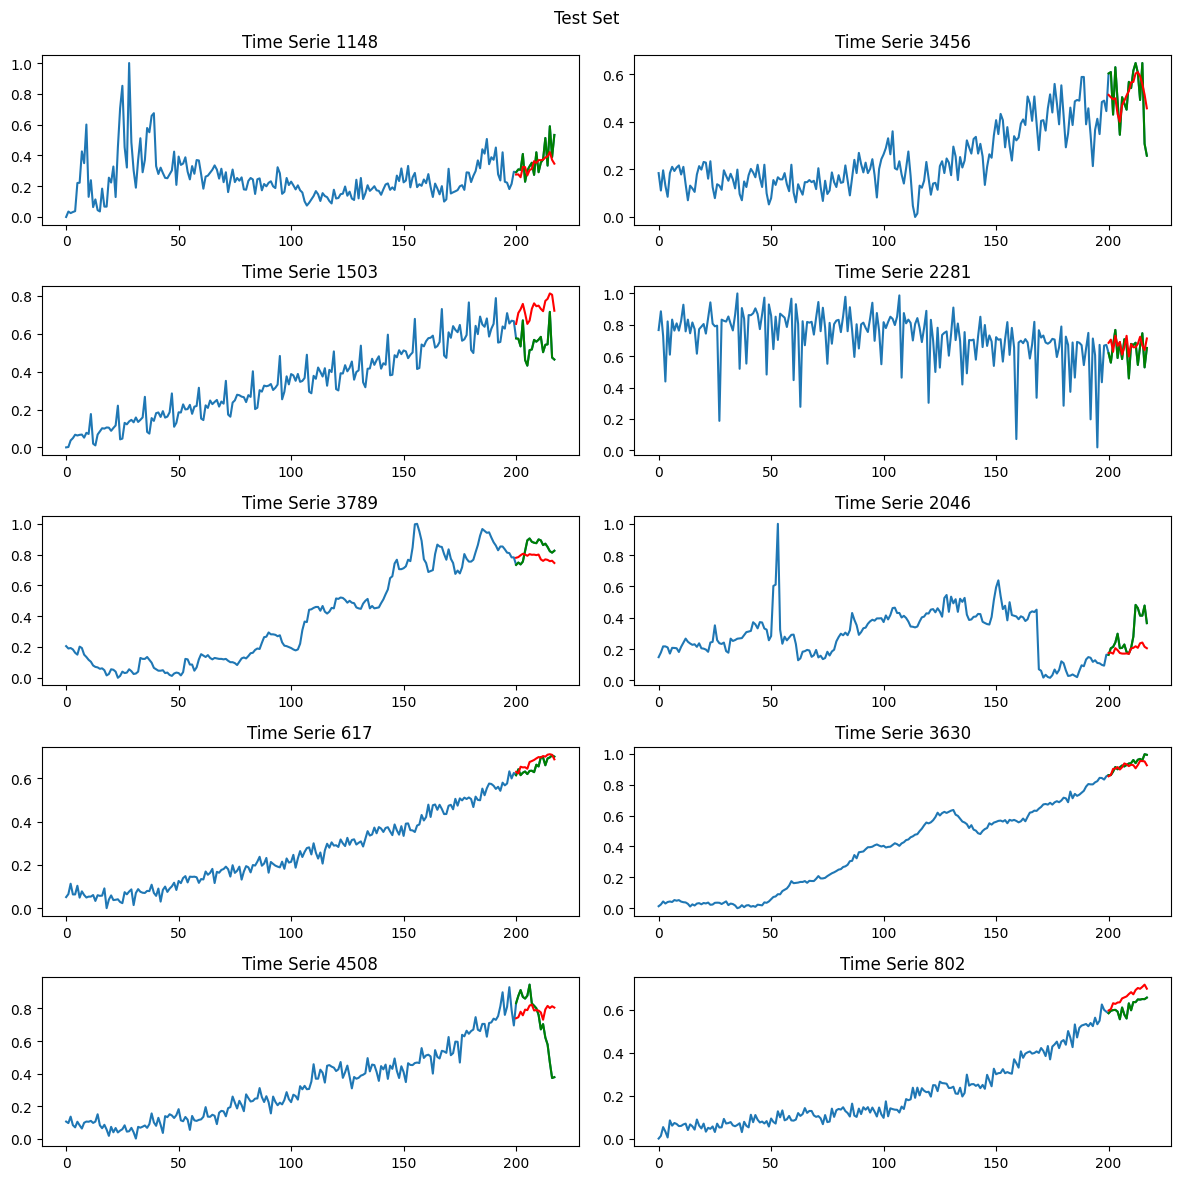

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(12, 12))

empty = np.zeros([x_test.shape[0], 200])
empty[empty == 0] = np.nan  # Set empty values to NaN

# Generate 2 random row indices
random_rows = random.sample(range(x_test.shape[0]), 10)

for i, row_index in enumerate(random_rows):
    row = i // 2
    col = i % 2
    axs[row, col].plot(np.concatenate((x_test[row_index], y_test[row_index])))
    axs[row, col].plot(np.concatenate((empty[row_index], y_test[row_index])), color='green')
    axs[row, col].plot(np.concatenate((empty[row_index], predictions[row_index])), color='red')
    axs[row, col].set_title(f'Time Serie {row_index}')

plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

### Robust Scaling

In [ ]:
# Load arrays from file
data = np.load('Stride_218_NORM_Data.npz')

# Access the loaded arrays
x_train, y_train, x_val, y_val, x_test, y_test = data['x_train'], data['y_train'], data['x_val'], data['y_val'], data['x_test'], data['y_test']

In [ ]:
from sklearn.preprocessing import RobustScaler

# Create a robust scaler
robust_scale = RobustScaler()

def inverse_robust_scale(data, center, scale):
    """
    Inverse scaling function for robust scaling.

    Parameters:
    - data: Scaled data to be inverted.
    - center: Median of the original data.
    - scale: Interquartile range (IQR) of the original data.

    Returns:
    - Inverted data in the original format.
    """
    return data * scale + center


# Robust scaling on training data
X_train_scaled = robust_scale.fit_transform(x_train)
y_train_scaled = robust_scale.fit_transform(y_train)
x_val_scaled = robust_scale.fit_transform(x_val)
y_val_scaled = robust_scale.fit_transform(y_val)

In [ ]:
from keras.layers import Input, LSTM, Bidirectional, Dense, Attention, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(200, 1)))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(18))

# Compile the model
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
model.fit(X_train_scaled, y_train_scaled, validation_data=(x_val_scaled, y_val_scaled), epochs=30, batch_size=32, callbacks = [
              tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=7, restore_best_weights=True),
              tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)
          ])

Epoch 1/30
512/512 [==============================] - 42s 56ms/step - loss: 0.0878 - val_loss: 0.0728 - lr: 0.0010
Epoch 2/30
512/512 [==============================] - 25s 48ms/step - loss: 0.0748 - val_loss: 0.0696 - lr: 0.0010
Epoch 3/30
512/512 [==============================] - 25s 49ms/step - loss: 0.0724 - val_loss: 0.0678 - lr: 0.0010
Epoch 4/30
512/512 [==============================] - 26s 52ms/step - loss: 0.0701 - val_loss: 0.0639 - lr: 0.0010
Epoch 5/30
512/512 [==============================] - 24s 48ms/step - loss: 0.0679 - val_loss: 0.0634 - lr: 0.0010
Epoch 6/30
512/512 [==============================] - 24s 46ms/step - loss: 0.0675 - val_loss: 0.0633 - lr: 0.0010
Epoch 7/30
512/512 [==============================] - 18s 34ms/step - loss: 0.0645 - val_loss: 0.0601 - lr: 0.0010
Epoch 8/30
512/512 [==============================] - 18s 35ms/step - loss: 0.0646 - val_loss: 0.0608 - lr: 0.0010
Epoch 9/30
512/512 [==============================] - 19s 37ms/step - loss: 0.06

In [ ]:
# Scale the new data for prediction
x_test_scaled = robust_scale.fit_transform(x_test)
y_test_scaled = robust_scale.fit_transform(y_test)

# Make predictions on the scaled data
predictions_scaled = model.predict(x_test_scaled)

# Invert the scaling to get predictions in the original data format
predictions_original_format = inverse_robust_scale(predictions_scaled, np.median(med_iq_vals), np.percentile(med_iq_vals, 75) - np.percentile(med_iq_vals, 25))

17/17 [==============================] - 0s 19ms/step


In [ ]:
# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test_scaled - predictions_scaled) ** 2)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.039882930952602196


In [ ]:
# Calculate Mean Squared Error (MSE)
mse = np.mean((y_test - predictions_original_format) ** 2)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.00994015321025844


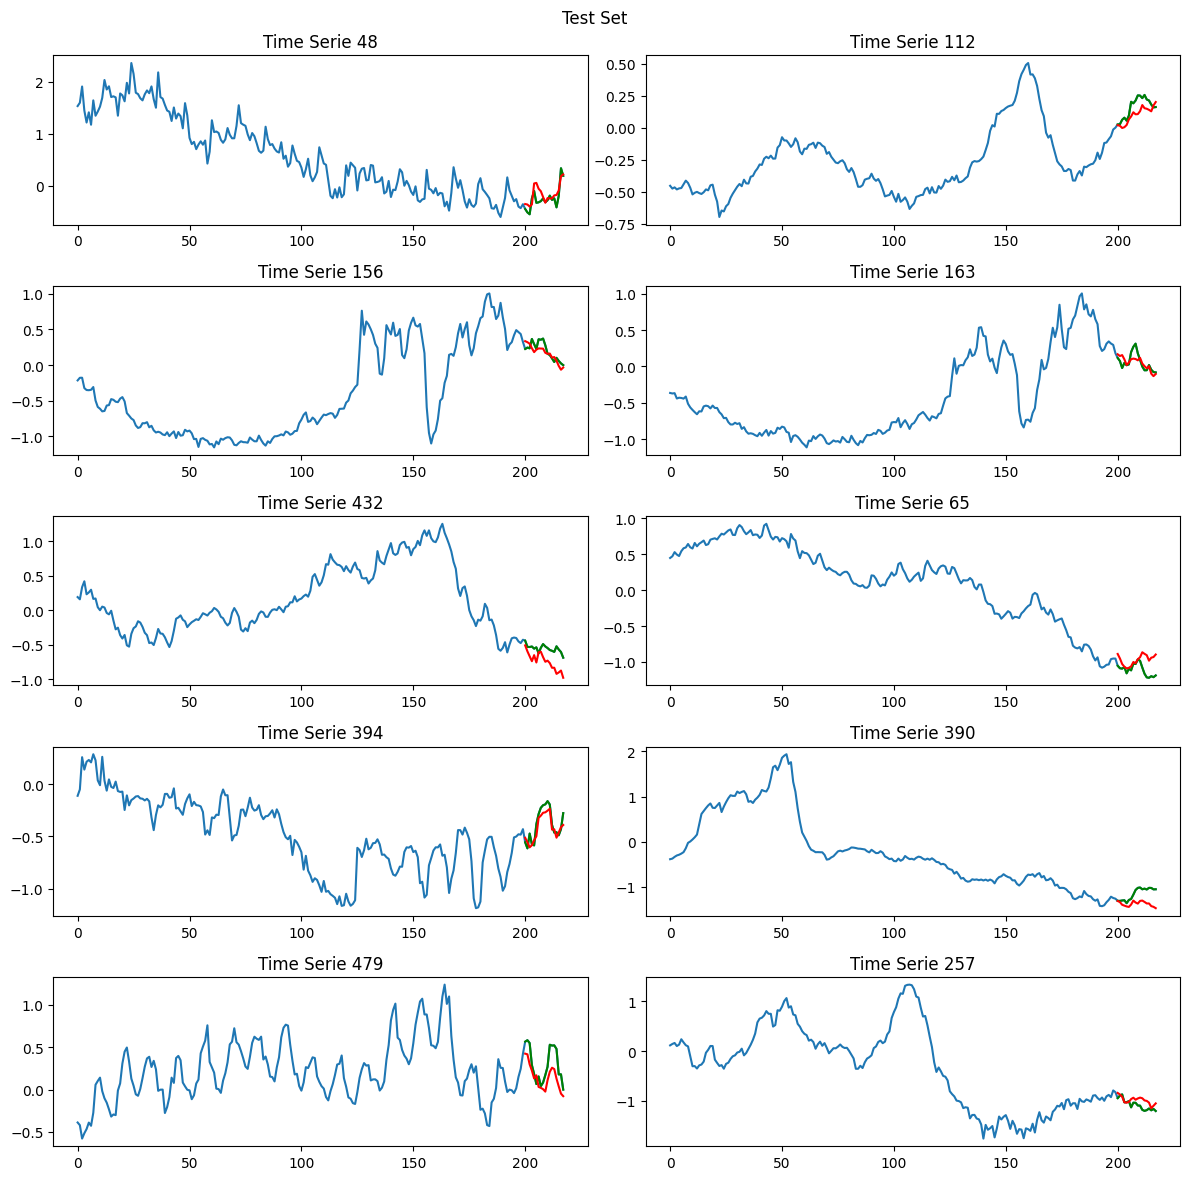

In [ ]:
# Create the figure and axes
figure, axes = plt.subplots(5, 2, figsize=(12, 12))

# Create an array filled with NaN values
empty = np.full((x_test.shape[0], 200), np.nan)

# Generate 2 random row indices
random_rows = random.sample(range(x_test.shape[0]), 10)

# Iterate through subplot grid
for i, ax in enumerate(axes.flatten()):
    row_index = random_rows[i]

    # Plot the original, green, and red lines with different line styles
    ax.plot(np.concatenate((x_test_scaled[row_index], y_test_scaled[row_index])))
    ax.plot(np.concatenate((empty[row_index], y_test_scaled[row_index])), color='green')
    ax.plot(np.concatenate((empty[row_index], predictions_scaled[row_index])), color='red')

    # Set the title
    ax.set_title(f'Time Serie {row_index}')

# Set the suptitle, adjust layout, and show the plot
plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

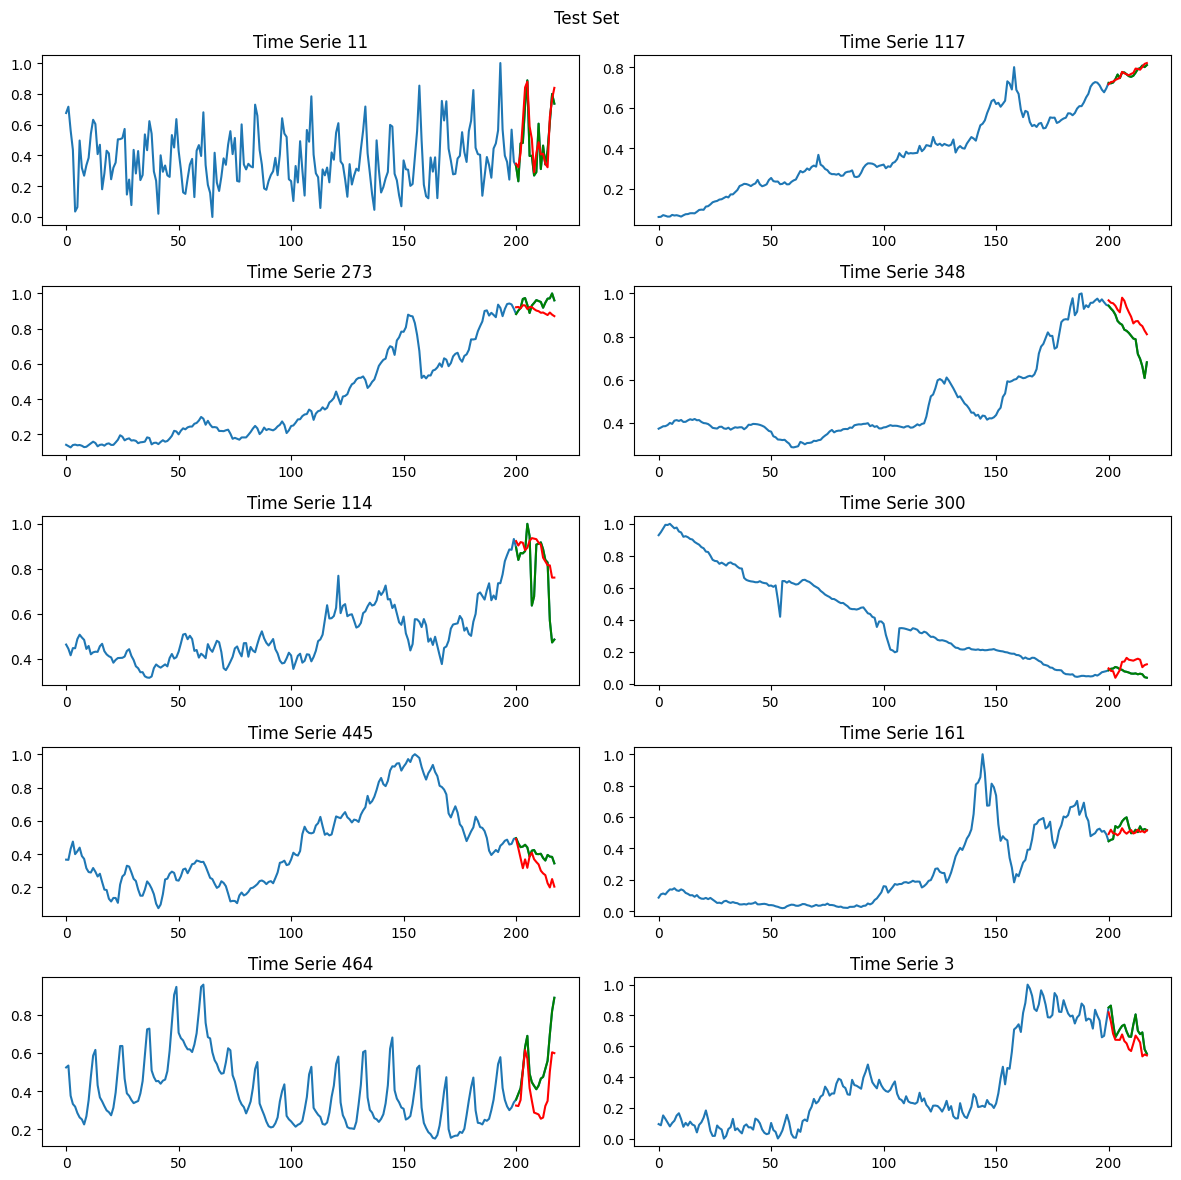

In [ ]:
# Create the figure and axes
figure, axes = plt.subplots(5, 2, figsize=(12, 12))

# Create an array filled with NaN values
empty = np.full((x_test.shape[0], 200), np.nan)

# Generate 2 random row indices
random_rows = random.sample(range(x_test.shape[0]), 10)

# Iterate through subplot grid
for i, ax in enumerate(axes.flatten()):
    row_index = random_rows[i]

    # Plot the original, green, and red lines with different line styles
    ax.plot(np.concatenate((x_test[row_index], y_test[row_index])))
    ax.plot(np.concatenate((empty[row_index], y_test[row_index])), color='green')
    ax.plot(np.concatenate((empty[row_index], predictions_original_format[row_index])), color='red')

    # Set the title
    ax.set_title(f'Time Serie {row_index}')

# Set the suptitle, adjust layout, and show the plot
plt.suptitle("Test Set")
plt.tight_layout()
plt.show()

In [ ]:
model.save("Robust_Scaler")

### ResNet + LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def resnet_branch(inputs, num_filters=64, kernel_size=3):
    x = Conv1D(num_filters, kernel_size, activation='relu')(inputs)
    x = MaxPooling1D(2)(x)
    x = GlobalAveragePooling1D()(x)
    return x

def lstm_branch(inputs, units=64):
    x = Bidirectional(LSTM(units, return_sequences=True))(inputs)
    x = Bidirectional(LSTM(units))(x)
    return x

# Assuming input_shape is the shape of your input time series data
input_shape = (200, 1)
inputs = Input(shape=input_shape)

# Define branches
resnet_output = resnet_branch(inputs)
lstm_output = lstm_branch(inputs)

# Concatenate the outputs of all branches
concatenated = tf.keras.layers.concatenate([resnet_output, lstm_output])

# Add additional dense layers for further processing
x = Dense(128, activation='relu')(concatenated)
x = Dropout(0.5)(x)
output = Dense(18, activation='linear')(x)  # Adjust output_dim based on your task

# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')  # Adjust loss function as needed

# Display the model summary
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 conv1d_21 (Conv1D)          (None, 198, 64)              256       ['input_7[0][0]']             
                                                                                                  
 max_pooling1d_4 (MaxPoolin  (None, 99, 64)               0         ['conv1d_21[0][0]']           
 g1D)                                                                                             
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 200, 128)             33792     ['input_7[0][0]']       

In [ ]:
# Train the model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=32, callbacks=[
    EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.1, min_lr=1e-5)
])

# Evaluate the model on the test set
mse = model.evaluate(x_test, y_test)

# Make predictions
predictions = model.predict(x_test)

Epoch 1/200
574/574 [==============================] - 24s 29ms/step - loss: 0.0358 - val_loss: 0.0136 - lr: 0.0010
Epoch 2/200
574/574 [==============================] - 15s 27ms/step - loss: 0.0180 - val_loss: 0.0123 - lr: 0.0010
Epoch 3/200
574/574 [==============================] - 16s 27ms/step - loss: 0.0156 - val_loss: 0.0118 - lr: 0.0010
Epoch 4/200
574/574 [==============================] - 16s 27ms/step - loss: 0.0141 - val_loss: 0.0111 - lr: 0.0010
Epoch 5/200
574/574 [==============================] - 16s 27ms/step - loss: 0.0132 - val_loss: 0.0109 - lr: 0.0010
Epoch 6/200
574/574 [==============================] - 16s 27ms/step - loss: 0.0129 - val_loss: 0.0109 - lr: 0.0010
Epoch 7/200
574/574 [==============================] - 16s 27ms/step - loss: 0.0127 - val_loss: 0.0109 - lr: 0.0010
Epoch 8/200
574/574 [==============================] - 15s 27ms/step - loss: 0.0125 - val_loss: 0.0105 - lr: 0.0010
Epoch 9/200
574/574 [==============================] - 16s 27ms/step - l

In [ ]:
# Evaluate the model on the test set
mse = model.evaluate(x_test, y_test)

# Make predictions
predictions = model.predict(x_test)

17/17 [==============================] - 0s 10ms/step


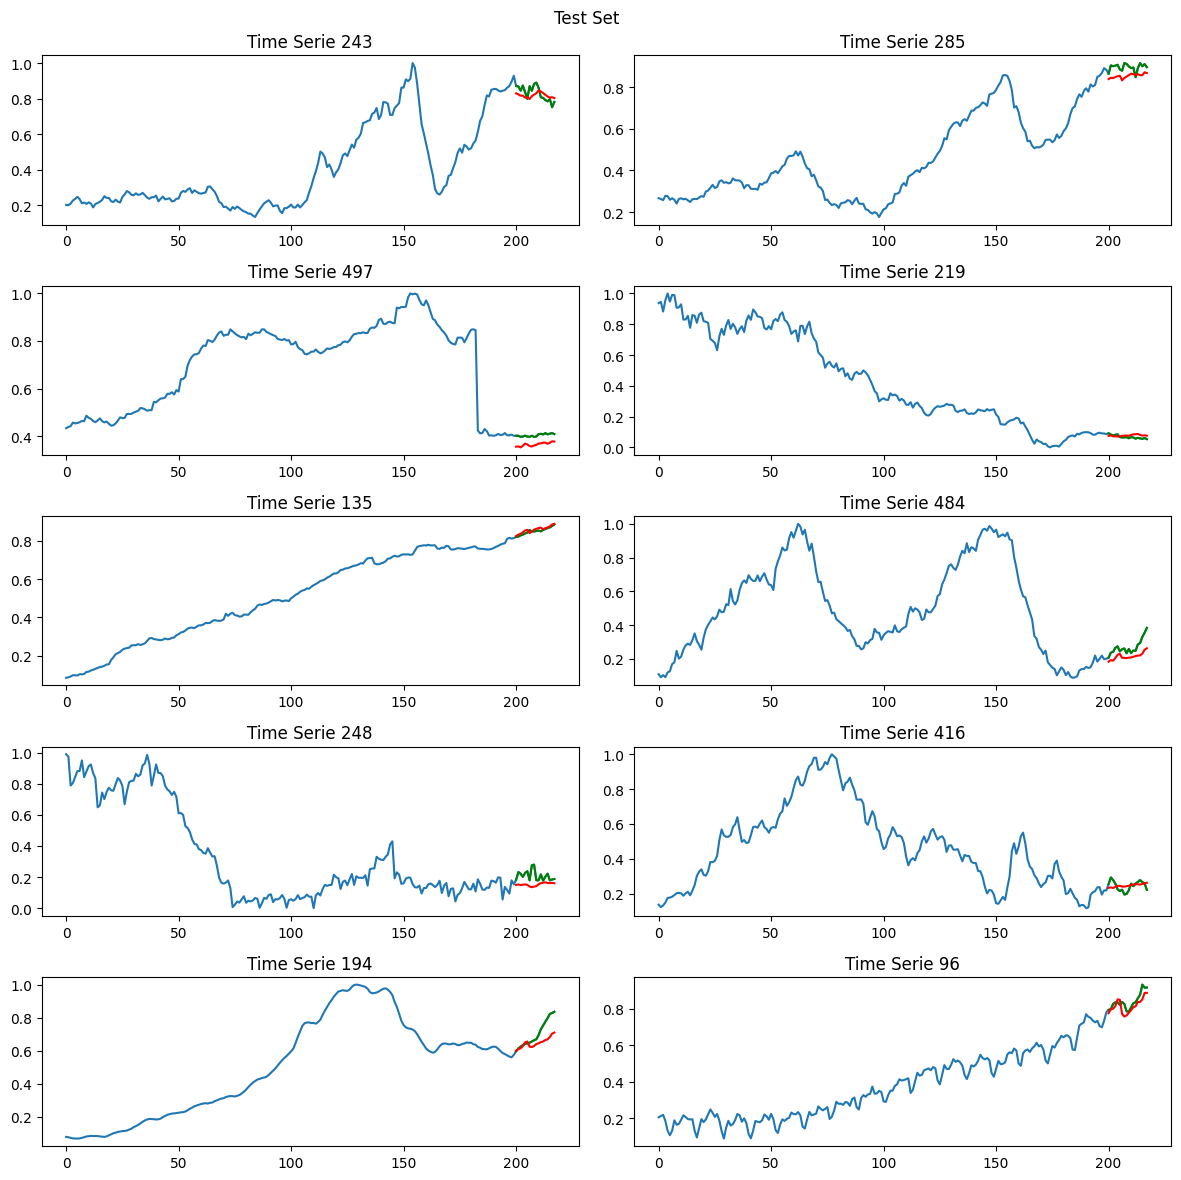

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(12, 12))

empty = np.zeros([x_test.shape[0], 200])
empty[empty == 0] = np.nan  # Set empty values to NaN

# Generate 2 random row indices
random_rows = random.sample(range(x_test.shape[0]), 10)

for i, row_index in enumerate(random_rows):
    row = i // 2
    col = i % 2
    axs[row, col].plot(np.concatenate((x_test[row_index], y_test[row_index])))
    axs[row, col].plot(np.concatenate((empty[row_index], y_test[row_index])), color='green')
    axs[row, col].plot(np.concatenate((empty[row_index], predictions[row_index])), color='red')
    axs[row, col].set_title(f'Time Serie {row_index}')

plt.suptitle("Test Set")
plt.tight_layout()
plt.show()